# Customer2Vec

In this notebook, we demonstrate how to learn embeddings for customers from transactional data using Doc2Vec. Each customer is viwed as a document, orders as sentences, and products as words. We also compare Customer2Vec with the baseline representations obtained using k-means on manually designed features.

### Data
We use an external dataset from the Instacart Market Basket Analysis competition (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datasets.md)). Please download and unzip the dataset to 'data' folder before running this notebook.

### References
1. Arora S., Warrier D. -- Decoding Fashion Contexts Using Word Embeddings, 2016
1. Stiebellehner S., Wang J, Yuan S. -- Learning Continuous User Representations through Hybrid Filtering with doc2vec, 2017

In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm.notebook import tqdm
import numpy as np
import os
from sklearn.manifold import TSNE
import sys

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 16


# Step 1: Data Exploration and Preparation

In [221]:
if sys.platform == 'linux': path_sep = '/'
elif sys.platform[:3] == 'win': path_sep = '\\'
else: path_sep = '/'

DATA_PATH = os.path.join(os.getcwd(), 'data', 'shwapno')
files_list = glob.glob(f'{DATA_PATH}/*.csv')

data_dict = {}

for file in files_list:
    # print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    # print(data.info(null_counts=True))
    data_dict[file.split('.')[0].split(path_sep)[-1]] = data

print(f'Loaded data sets: {data_dict.keys()}')

Loaded data sets: dict_keys(['category', 'invoice_data', 'invoice_details', 'products', 'subcategory'])


In [222]:
data_dict['invoice_details']

,Invoiceno,CustomerCode,ProductCode,ProductName,SalesQTY,PrepareDate,WeekEndFlag,DayTimeFlag,Reordered
0,D0072007100044,1300840656,2809267,Olympic Butter Bite Biscuits 73g,2.0,2020-07-10 09:48:22.180,1,Morning,0
1,D0072007100044,1300840656,2802983,Sun Chips Mix Masala 38 gm,8.0,2020-07-10 09:48:22.180,1,Morning,0
2,D0072007100044,1300840656,2300253,Coca Cola 250 ml can,5.0,2020-07-10 09:48:22.180,1,Morning,0
3,D0072007100044,1300840656,2802985,Sun Chips Mix Masala 80 gm,3.0,2020-07-10 09:48:22.180,1,Morning,0
4,D0072007100044,1300840656,2806314,Ruchi Orange Jam 480gm,1.0,2020-07-10 09:48:22.180,1,Morning,0
...,...,...,...,...,...,...,...,...,...
2193575,D0071711050626,99099972,2600102,Vim Dish Wash Liquid 500ml (Bottle),1.0,2017-11-05 17:23:15.190,0,Afternoon,0
2193576,D0071711050626,99099972,2600541,Odonil Mystic Rose Air Freshner50g(Hang),1.0,2017-11-05 17:23:15.190,0,Afternoon,0
2193577,D0071711050626,99099972,2401186,BPM Rice Flour 1kg,2.0,2017-11-05 17:23:15.190,0,Afternoon,0
2193578,D0071711050626,99099972,2702688,BPM Gram Flour 500g,1.0,2017-11-05 17:23:15.190,0,Afternoon,0


Generate the invoice details file

In [ ]:
documents=None, corpus_file=None, vector_size=100, dm_mean=None, dm=1, dbow_words=0, dm_concat=0,
            dm_tag_count=1, dv=None, dv_mapfile=None, comment=None, trim_rule=None, callbacks=(),
            window=5, epochs=10, shrink_windows=True, **kwargs,

In [231]:
invoice_details = data_dict['invoice_details']
invoice_details['PrepareDate'] = pd.to_datetime(invoice_details['PrepareDate'])
invoice_details.ProductCode = invoice_details.ProductCode.astype(str)
invoice_rank = invoice_details[['CustomerCode', 'PrepareDate', 'Invoiceno']].drop_duplicates().groupby(['CustomerCode'])['Invoiceno'].rank(method="first", ascending=True)
invoice_details['OrderNo'] = invoice_rank.reindex_like(invoice_details, method='pad').astype(int)

In [232]:
invoice_details

,Invoiceno,CustomerCode,ProductCode,ProductName,SalesQTY,PrepareDate,WeekEndFlag,DayTimeFlag,Reordered,OrderNo
0,D0072007100044,1300840656,2809267,Olympic Butter Bite Biscuits 73g,2.0,2020-07-10 09:48:22.180,1,Morning,0,1
1,D0072007100044,1300840656,2802983,Sun Chips Mix Masala 38 gm,8.0,2020-07-10 09:48:22.180,1,Morning,0,1
2,D0072007100044,1300840656,2300253,Coca Cola 250 ml can,5.0,2020-07-10 09:48:22.180,1,Morning,0,1
3,D0072007100044,1300840656,2802985,Sun Chips Mix Masala 80 gm,3.0,2020-07-10 09:48:22.180,1,Morning,0,1
4,D0072007100044,1300840656,2806314,Ruchi Orange Jam 480gm,1.0,2020-07-10 09:48:22.180,1,Morning,0,1
...,...,...,...,...,...,...,...,...,...,...
2193575,D0071711050626,99099972,2600102,Vim Dish Wash Liquid 500ml (Bottle),1.0,2017-11-05 17:23:15.190,0,Afternoon,0,2
2193576,D0071711050626,99099972,2600541,Odonil Mystic Rose Air Freshner50g(Hang),1.0,2017-11-05 17:23:15.190,0,Afternoon,0,2
2193577,D0071711050626,99099972,2401186,BPM Rice Flour 1kg,2.0,2017-11-05 17:23:15.190,0,Afternoon,0,2
2193578,D0071711050626,99099972,2702688,BPM Gram Flour 500g,1.0,2017-11-05 17:23:15.190,0,Afternoon,0,2


Split into test and trial (prior) sets

In [233]:
test_date = pd.to_datetime('1 January, 2022')

prior_orders  = invoice_details.loc[invoice_details['PrepareDate'] < test_date]
test_orders  = invoice_details.loc[invoice_details['PrepareDate'] >= test_date]

# Step 2: Establish the Baselines

We start with designing several basic features and segmenting customers using this basic representation. Note that the dataset is limited and does not allow for advanced ferature engineering (there is no demographic data, etc).

### Step 2.1: Feature Engineering

In [234]:
# Sample users to keep the problem computationaly tractable
USER_SUBSET = 50000
user_ids_sample = prior_orders['CustomerCode'].sample(n=USER_SUBSET, replace=False)

prior_orders_details = prior_orders[prior_orders.CustomerCode.isin(user_ids_sample)].copy()
# prior_orders_details['ProductCode'] = prior_orders_details['ProductCode'].astype(int)
prior_orders_details = prior_orders_details[['Invoiceno', 'ProductCode', 'Reordered', 'CustomerCode', 'OrderNo']].merge(data_dict['products'], on='ProductCode', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['subcategory'], on='SubCategoryID', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['category'], on='CategoryID', how='left')

prior_orders_details.head(40)

,Invoiceno,ProductCode,Reordered,CustomerCode,OrderNo,ProductName,SubCategoryID,CategoryID,SubCategory,Category
0,D0072007100044,2809267,0,1300840656,1,Olympic Butter Bite Biscuits 73g,2802,28,Biscuits,Packaged Foods
1,D0072007100044,2802983,0,1300840656,1,Sun Chips Mix Masala 38 gm,2809,28,Snacks,Packaged Foods
2,D0072007100044,2300253,0,1300840656,1,Coca Cola 250 ml can,2301,23,Carbonated Drink,Beverage & Tobacco
3,D0072007100044,2802985,0,1300840656,1,Sun Chips Mix Masala 80 gm,2809,28,Snacks,Packaged Foods
4,D0072007100044,2806314,0,1300840656,1,Ruchi Orange Jam 480gm,2810,28,Spreads,Packaged Foods
5,D0072007100044,2804454,0,1300840656,1,Sunfeast Dark Fantasy Choco Fills 75g,2802,28,Biscuits,Packaged Foods
6,D0072007100044,2805741,0,1300840656,1,Olympic Digestive Biscuits 110g,2802,28,Biscuits,Packaged Foods
7,D0072007100044,2807630,0,1300840656,1,Poppers Corn Coconut Crackers 25g,2809,28,Snacks,Packaged Foods
8,D0072007100044,2812946,0,1300840656,1,Nestle KitKat 41.5±5g(4Fin 2Pc Value Pk),2805,28,Chocolates,Packaged Foods
9,D0072007100044,2812026,0,1300840656,1,Olympic Black Cream Biscuit 85g,2802,28,Biscuits,Packaged Foods


In [235]:
# Create basic user features: relative purchase frequences in each depertment/aisle

feature_department = pd.pivot_table(prior_orders_details, index=['CustomerCode'], values=['ProductCode'], columns=['Category'], aggfunc='count', fill_value=0)

feature_department = feature_department.div(feature_department.sum(axis=1), axis=0)

feature_department.columns = feature_department.columns.droplevel(0)

feature_department = feature_department.reset_index()

feature_aisle = pd.pivot_table(prior_orders_details, index=['CustomerCode'], values=['ProductCode'], columns=['SubCategory'], aggfunc='count', fill_value=0)
feature_aisle = feature_aisle.div(feature_aisle.sum(axis=1), axis=0)
feature_aisle.columns = feature_aisle.columns.droplevel(0)
feature_aisle = feature_aisle.reset_index()

feature_df = feature_department.merge(feature_aisle, how='left', on='CustomerCode').set_index('CustomerCode')
#
feature_df.iloc[:5, :10] # show first 10 columns (departments) only

,Accent & Decors,Baby Care,Baby Food,Beverage & Tobacco,Commodities,Consumable Material,Dairy,Electronics & Appliances,Gift & Toys,HOME MADE
CustomerCode,,,,,,,,,,
2213257,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.0
3074467,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.062500,0.0,0.00000,0.0
3260015,0.0,0.0,0.0,0.219512,0.073171,0.02439,0.121951,0.0,0.02439,0.0
3260023,0.0,0.0,0.0,0.069767,0.000000,0.00000,0.069767,0.0,0.00000,0.0
3260030,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.0


In [236]:
len(feature_df.columns)

123

### Step 2.2: Visualize the Basic Space Using t-SNE  

In [237]:
from sklearn.preprocessing import MinMaxScaler

mm_scale = MinMaxScaler()
feature_df_scale = pd.DataFrame(mm_scale.fit_transform(feature_df),
                                columns=feature_df.columns,
                                index=feature_df.index.values)

tsne_doc_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_features_doc = tsne_doc_features.fit_transform(feature_df_scale.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12207 samples in 0.011s...
[t-SNE] Computed neighbors for 12207 samples in 0.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12207
[t-SNE] Computed conditional probabilities for sample 2000 / 12207
[t-SNE] Computed conditional probabilities for sample 3000 / 12207
[t-SNE] Computed conditional probabilities for sample 4000 / 12207
[t-SNE] Computed conditional probabilities for sample 5000 / 12207
[t-SNE] Computed conditional probabilities for sample 6000 / 12207
[t-SNE] Computed conditional probabilities for sample 7000 / 12207
[t-SNE] Computed conditional probabilities for sample 8000 / 12207
[t-SNE] Computed conditional probabilities for sample 9000 / 12207
[t-SNE] Computed conditional probabilities for sample 10000 / 12207
[t-SNE] Computed conditional probabilities for sample 11000 / 12207
[t-SNE] Computed conditional probabilities for sample 12000 / 12207
[t-SNE] Computed conditional probabilities for sam

In [238]:
tsne_doc_features = pd.DataFrame({'CustomerCode':feature_df.index.values})
tsne_doc_features['tsne-2d-one'] = tsne_features_doc[:,0]
tsne_doc_features['tsne-2d-two'] = tsne_features_doc[:,1]

<Figure size 1600x1600 with 0 Axes>

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

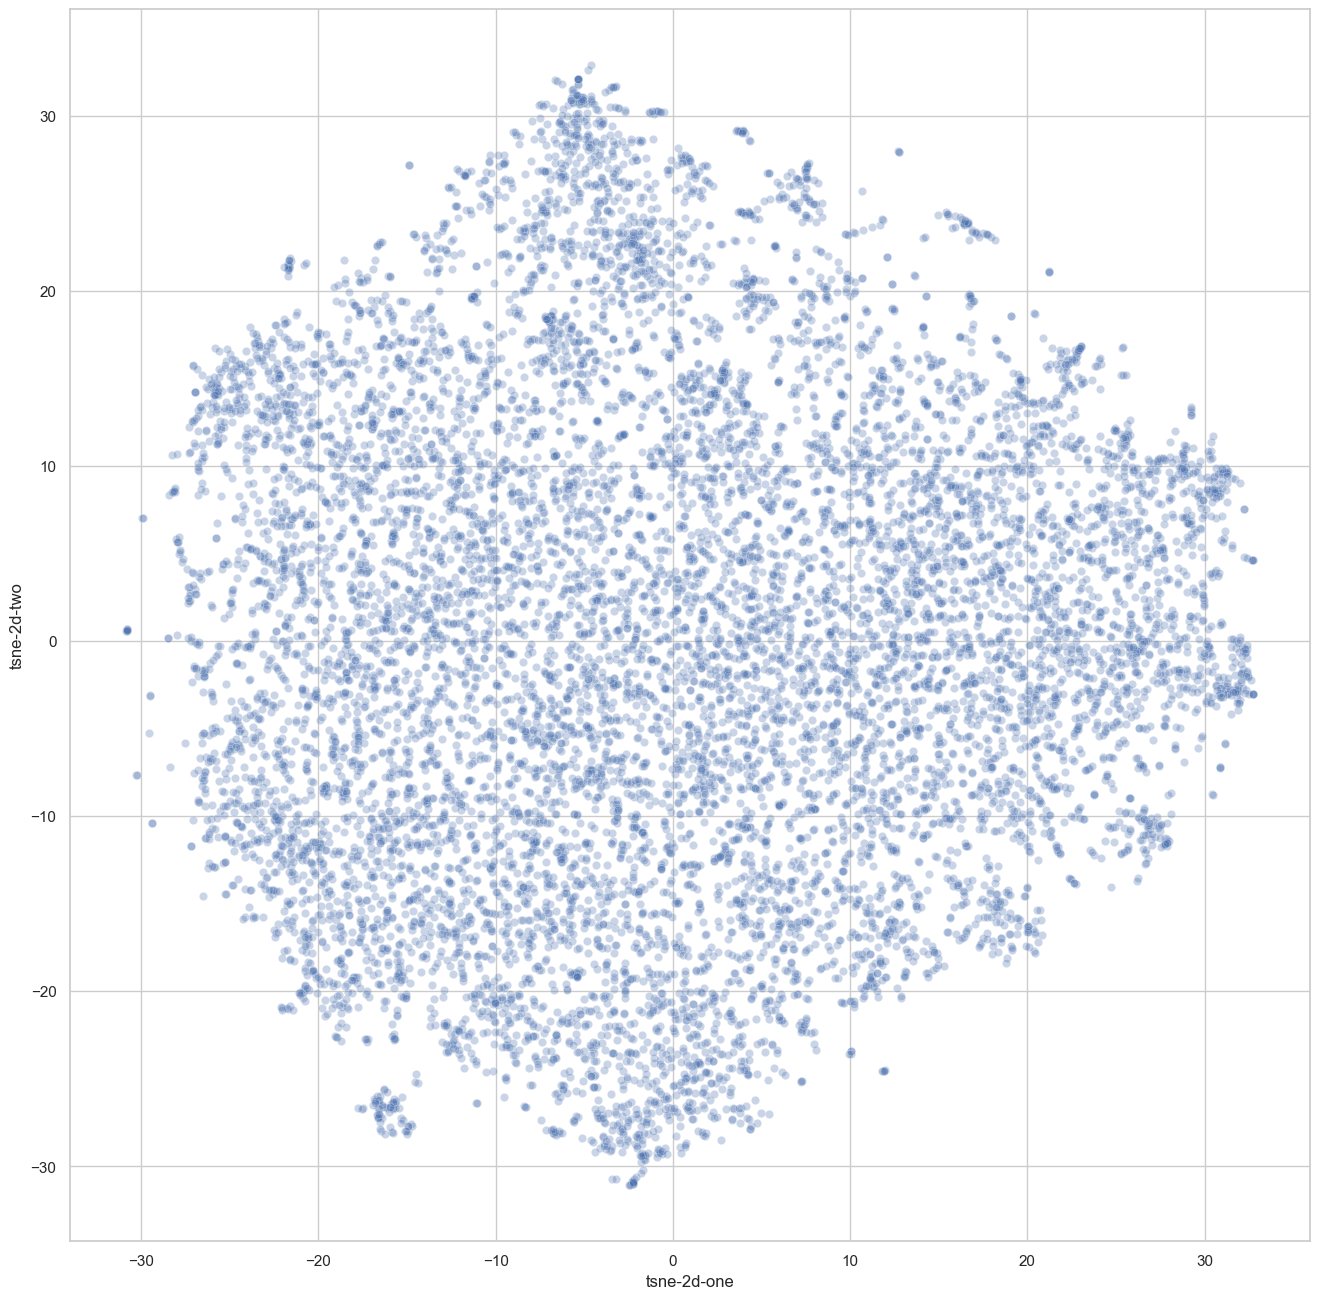

In [239]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc_features,
    legend="full",
    alpha=0.3
)
plt.show()

In [240]:
# Computing silhouette scores for different clustering option
silhouette_list = []
for k in tqdm(range(2, 12, 2)):
    clusters = KMeans(n_clusters=k, n_init=10).fit(feature_df_scale).labels_.astype(float)
    silhouette_avg = silhouette_score(feature_df_scale, clusters, metric="euclidean")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

C:\Users\shadm\AppData\Local\Temp\ipykernel_18920\4166228548.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(2, 12, 2)):


  0%|          | 0/5 [00:00<?, ?it/s]

Silhouette score for 2 clusters is : 0.09983
Silhouette score for 4 clusters is : 0.09792
Silhouette score for 6 clusters is : 0.07546
Silhouette score for 8 clusters is : 0.06478
Silhouette score for 10 clusters is : 0.05374


<Figure size 1000x600 with 0 Axes>

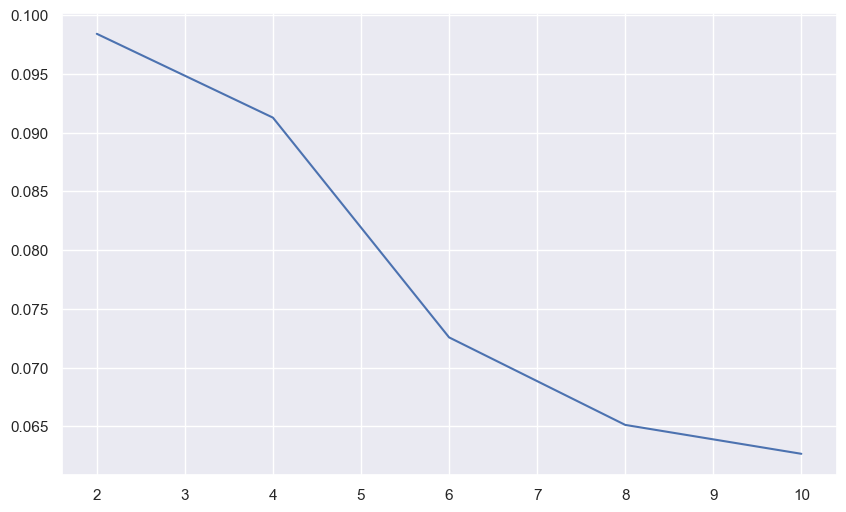

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 12, 2), silhouette_list)

Conclusions: We can see from the t-SNE visualization it is possible to detect 2-3 clusters, but the silhouette score is close to zero and this feature space is not a good choice for customer segmentation. 
We should develop more advanced features and incorporate more domain knowledge to obtain better feature space for segmentation.

# Step 3: Customer2Vec Using Doc2Vec

In this and next section, we are learning and exploring the customer semantic space using Doc2Vec.

### Step 3.1: Data Preparation

In [244]:
test_orders["ProductCode"] = test_orders["ProductCode"].astype(str)
prior_orders["ProductCode"] = prior_orders["ProductCode"].astype(str)

# It is important to sort order and products chronologically
prior_orders.sort_values(by=['CustomerCode','OrderNo'], inplace=True)
prior_orders

C:\Users\shadm\AppData\Local\Temp\ipykernel_18920\32837731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_orders["ProductCode"] = test_orders["ProductCode"].astype(str)
C:\Users\shadm\AppData\Local\Temp\ipykernel_18920\32837731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_orders["ProductCode"] = prior_orders["ProductCode"].astype(str)
C:\Users\shadm\AppData\Local\Temp\ipykernel_18920\32837731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,Invoiceno,CustomerCode,ProductCode,ProductName,SalesQTY,PrepareDate,WeekEndFlag,DayTimeFlag,Reordered,OrderNo
559493,D0071609091129,2213257,2600576,Diamond Aluminium Foil 37.5 SQ.FT.,1.0,2016-09-09 16:48:15.697,1,Afternoon,0,1
559494,D0071609091129,2213257,2806289,E.F Lingo Fish Cake 500g,1.0,2016-09-09 16:48:15.697,1,Afternoon,0,1
559495,D0071609091129,2213257,2806281,E.F Fish Tofu Square 500g,1.0,2016-09-09 16:48:15.697,1,Afternoon,0,1
559496,D0071609091129,2213257,3802706,S201047 Pata salad cutter,1.0,2016-09-09 16:48:15.697,1,Afternoon,0,1
559497,D0071606241988,2213454,3012832,Dettol Cool H.W.170ml(Buy2 Get1 Free),1.0,2016-06-24 21:46:41.107,1,Night,0,1
...,...,...,...,...,...,...,...,...,...,...
559488,D0072102280327,1999997535,2802217,Snickers Single 50g,1.0,2021-02-28 14:49:23.713,0,Afternoon,0,10
559489,D0072102280327,1999997535,2807162,Romania Coconut Milk Biscuit 60g,1.0,2021-02-28 14:49:23.713,0,Afternoon,0,10
559490,D0072102280327,1999997535,2807130,Nestle Kit Kat Chocolate 20.5±2.8g,1.0,2021-02-28 14:49:23.713,0,Afternoon,0,10
559491,D0072102280327,1999997535,2400365,Confidence Salt 1 kg,3.0,2021-02-28 14:49:23.713,0,Afternoon,0,10


In [245]:
combined_orders_by_user_id = prior_orders.groupby("CustomerCode").apply(lambda order: ' '.join(order['ProductCode'].tolist()))

combined_orders_by_user_id = pd.DataFrame(combined_orders_by_user_id,columns=['all_orders'])
print(f'Number of customers: {combined_orders_by_user_id.shape[0]}')
combined_orders_by_user_id.reset_index(inplace=True)
combined_orders_by_user_id['CustomerCode'] = combined_orders_by_user_id['CustomerCode'].astype(str)

combined_orders_by_user_id

Number of customers: 19579


,CustomerCode,all_orders
0,2213257,2600576 2806289 2806281 3802706
1,2213454,3012832 2600082 2500907 2901290 2812947 3002936 2812947 3102046 2500053 2500267 2500053 3102046 2500576 3002936 2500576 4004731 2901290 2500267 2901290 4004731 6000135 3000356 6000135 3000356 3809667 3809667 2901141 2901141 2200277 2200277
2,3074467,2802215 2805416 2805119 2800248 2802217 2805948 2806794 2802924 2810557 2500011 2801449 3005434 2811439 2812265 2803206 2810517
3,3077018,2801431 2811648 2500576 2702764 2806604 2804221 2814251 2807630 2300782 2300962 2809383 2811831 2702707 2702701 3807079 2602899 2806193 3811696
4,3260015,2806026 2300135 2806026 2500138 2300135 2500138 2600078 2600078 2700755 2700755 2302294 2302294 2500002 2500002 2700754 2700754 3002961 3002961 2400029 2500087 2808310 2500087 2400029 2603491 2808310 2603491 2501099 2803204 3807256 2803204 2501099 2803631 3807256 2803631 2701092 2700281 2300499 2700281 2701092 2700853 2300499 2700853 2702683 2400003 6000135 2400003 2702683 2601252 6000135 2601252 2701782 2701782 2806797 2806797 2401008 2401008 2810093 2810093 2500045 2300192 2300364 2500045 ...
...,...,...
19574,1998766247,2400019 2700292 2701227 2702143 2700073 2702141 2700909 2702451 4213063 4213018 2400346 4213018 2703462 3010925 2400346 3010925 4213063 2400377 2703462 2400377 2701016 2812487 3014593 2812487 2701016 3014593 2700491 3807079 2700491 3807079 2803904 2701879 2803904 2701879 3006445 2702925 3006445 2702925 6000135 6000135 2301843 2301843 2701307 2701307 2701535 2701535 2101024 2600067 2200674 2812351 2101046 2802723 3014922 2102020 2101285 2802925 2101635 3014227 2603523 2812075 2814213 3015323 ...
19575,1998872660,2101278 6000133 2101911 3014609 3004890 6000137 2500088 6000137 2812571 4211765 2803662 2601381 3007910 3003575 2601378 3008195 3002862 3007441 3014220 6000140 2601381 2101954 3000979 2600070 3002783 2603443 3002862 3003576 3012368 3001306 3013932 3007909 2101397 3013769 3012372 3003527 2812032 6000137 6000162 2301456 2802925 3009181 6000133 6000137 2802698 2501235 3002777 2301626 3003710 2700060 2702941 2813348 2813347 2813709 3007507 3015633 2501113 3014609 3008195 3002962 3016077 3016049 ...
19576,1999524856,2812888 2812886 2501230 2812891 2800291 2812877 6000140 2501113 2400569 2701088 2501235 2300783 2700291 3014598 3012857
19577,1999916558,2807983 2800038 2800842 2812429 2811535 3008316 2808571 6000140 2811534 2811534 2700016 2800842 2802970 2809358 2301355 2300135 2803662 2500289


### Step 3.2: Train Doc2Vec model

We use implementation from Gensim adjusting the following parameters:
* documents = users (each user is represented by a chronologically sorted list of products)
* window - Maximum distance between the current and predicted word within a sentence.
* vector_size - Dimensionality of the word vectors.
* min_count - Ignores all words with total frequency lower than this.

Note that model training can take a long time (10+ hours).

In [246]:
TRAIN_USER_MODEL = True    # True - create a new model, False - load a previosuly created model
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [197]:
def fancy_generator():
    my_list = [1, 2, 3, 4]
    for i in my_list:
        yield i * 2

mygen = fancy_generator()
lmgen = list(fancy_generator())

print(lmgen)

2

## Training block

In [269]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

embeddings_dim = 50    # dimensionality of user representation
filename = f'models/customer2vec.{embeddings_dim}d.model'

class TaggedDocumentIterator(object):
    def __init__(self, df):
       self.df = df
    def __iter__(self):
        for row in self.df.itertuples():
            yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['CustomerCode']])


if TRAIN_USER_MODEL or not os.path.exists(os.path.join(MODEL_DIR, filename)):
    train_corpus = TaggedDocumentIterator(combined_orders_by_user_id)
    doc_model = Doc2Vec(documents=train_corpus,
                        vector_size=embeddings_dim,
                        window=5,
                        min_count=10,
                        workers=mp.cpu_count(),
                        alpha=0.055,
                        min_alpha=0.055,
                        epochs=120)
    doc_model.save(filename)
    print(f'Model saved to [{filename}]')
else:
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

KeyboardInterrupt: 

Model saved to [models/customer2vec.200d.model]


In [ ]:
# np.shape(doc_model.wv.index_to_key)

In [257]:
vocab_doc = list(doc_model.dv.index_to_key)
doc_vector_dict = {arg:doc_model.docvecs[arg] for arg in vocab_doc}
X_doc = pd.DataFrame(doc_vector_dict).T.values


X_doc.shape, len(vocab_doc), prior_orders["CustomerCode"].nunique()

C:\Users\shadm\AppData\Local\Temp\ipykernel_18920\1824433171.py:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  doc_vector_dict = {arg:doc_model.docvecs[arg] for arg in vocab_doc}


((19579, 200), 19579, 19579)

### Step 3.3: Visualize the Customer Semantic Space Using t-SNE

In [258]:
user_ids_sample_str = set([str(id) for id in user_ids_sample])
idx = []
for i, user_id in enumerate(doc_vector_dict):
    if user_id in user_ids_sample_str:
        idx.append(i)
X_doc_subset = X_doc[idx] # only sampled user IDs
X_doc_subset.shape

(12207, 200)

In [259]:
doc_vec_subset = pd.DataFrame(doc_vector_dict).T.iloc[idx]
doc_vec_subset.shape

(12207, 200)

In [261]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc_subset, X_doc_subset, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500, init='random')
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12207 samples in 1.061s...
[t-SNE] Computed neighbors for 12207 samples in 1.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12207
[t-SNE] Computed conditional probabilities for sample 2000 / 12207
[t-SNE] Computed conditional probabilities for sample 3000 / 12207
[t-SNE] Computed conditional probabilities for sample 4000 / 12207
[t-SNE] Computed conditional probabilities for sample 5000 / 12207
[t-SNE] Computed conditional probabilities for sample 6000 / 12207
[t-SNE] Computed conditional probabilities for sample 7000 / 12207
[t-SNE] Computed conditional probabilities for sample 8000 / 12207
[t-SNE] Computed conditional probabilities for sample 9000 / 12207
[t-SNE] Computed conditional probabilities for sample 10000 / 12207
[t-SNE] Computed conditional probabilities for sample 11000 / 12207
[t-SNE] Computed conditional probabilities for sample 12000 / 12207
[t-SNE] Computed conditional probabilities for sam

In [262]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 1600x1600 with 0 Axes>

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

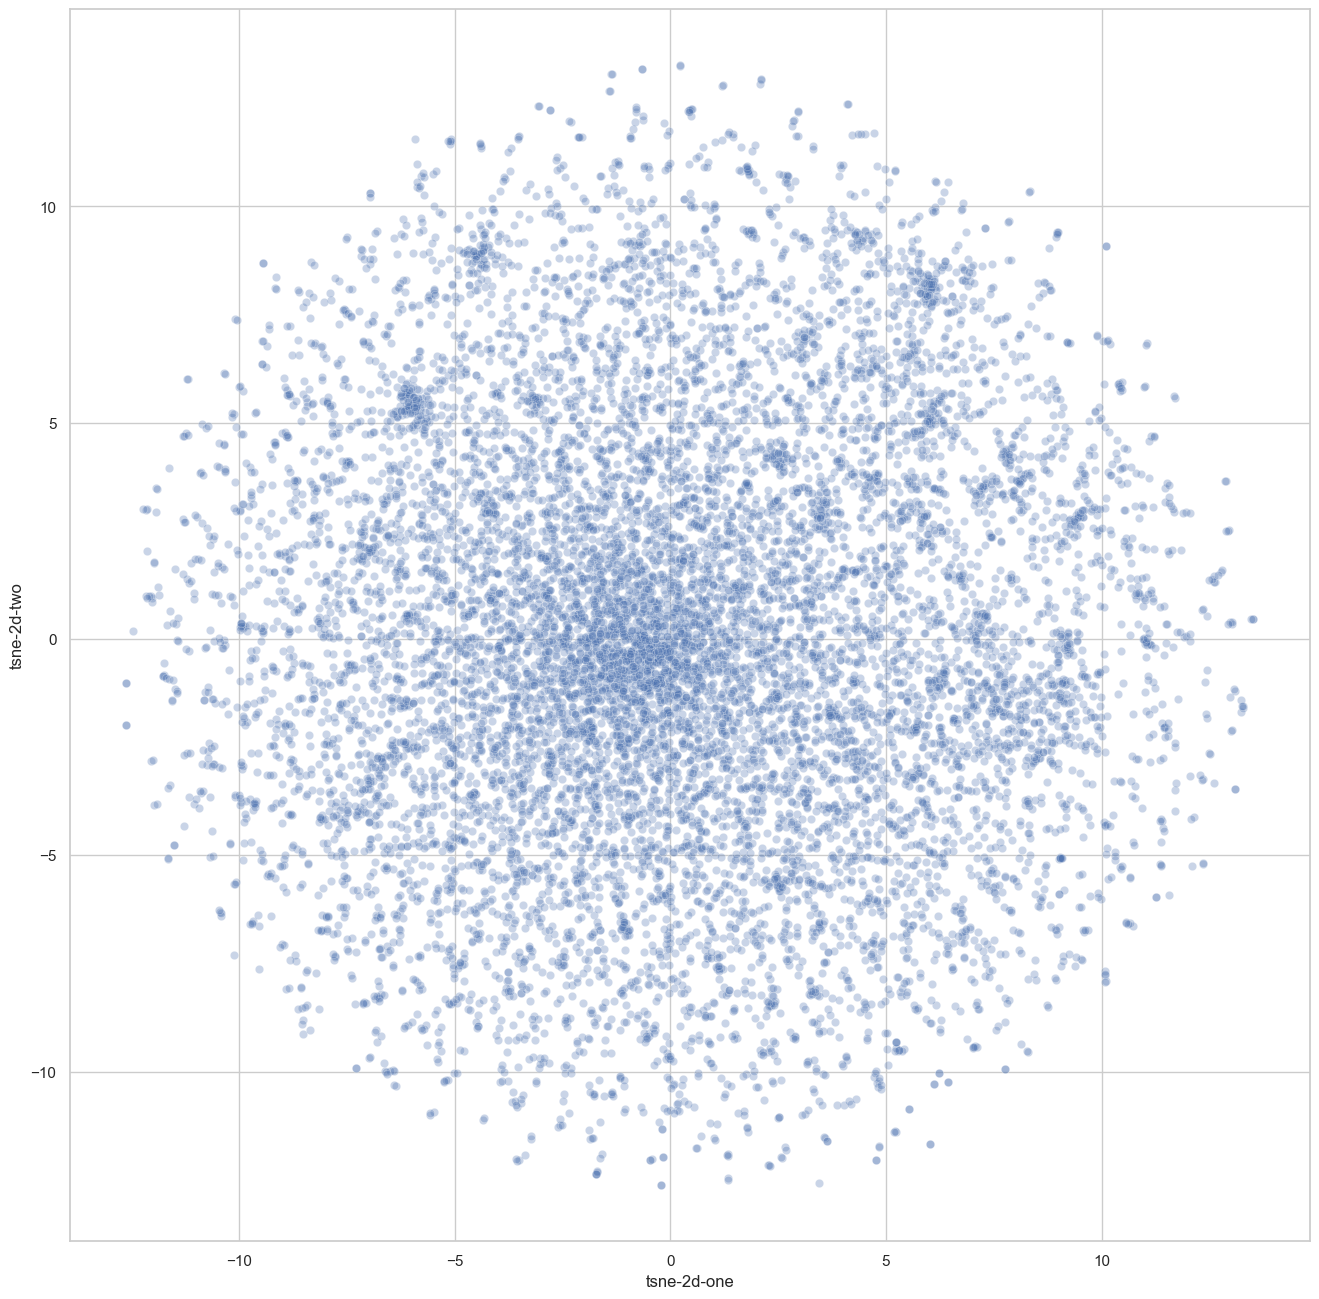

In [263]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

### Step 3.4: Segmentation in the Customer Semantic Space Using t-SNE

In [277]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k, n_init=10).fit(preprocessing.normalize(X_doc_subset))

silhouette_list = []
Sum_of_squared_distances = []
for k in tqdm(range(2, 30, 1)):
    latent_clusters = cluster_cosine(X_doc_subset, k)
    Sum_of_squared_distances.append(latent_clusters.inertia_)
    silhouette_avg = silhouette_score(X_doc_subset, latent_clusters.labels_.astype(float), metric="cosine")
    silhouette_list.append(silhouette_avg)
    # print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

  0%|          | 0/28 [00:00<?, ?it/s]

Silhouette score for 2 clusters is : 0.01687
Silhouette score for 3 clusters is : -0.005764
Silhouette score for 4 clusters is : -0.01371
Silhouette score for 5 clusters is : -0.02013
Silhouette score for 6 clusters is : -0.02653
Silhouette score for 7 clusters is : -0.02856
Silhouette score for 8 clusters is : -0.03397
Silhouette score for 9 clusters is : -0.03238
Silhouette score for 10 clusters is : -0.03589
Silhouette score for 11 clusters is : -0.03645
Silhouette score for 12 clusters is : -0.0383
Silhouette score for 13 clusters is : -0.04679
Silhouette score for 14 clusters is : -0.03845
Silhouette score for 15 clusters is : -0.05434
Silhouette score for 16 clusters is : -0.03828
Silhouette score for 17 clusters is : -0.03788
Silhouette score for 18 clusters is : -0.05696
Silhouette score for 19 clusters is : -0.04757
Silhouette score for 20 clusters is : -0.06208
Silhouette score for 21 clusters is : -0.04569
Silhouette score for 22 clusters is : -0.04733
Silhouette score for 2

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'Silhouette score')

Text(0, 0.5, 'Inertia score')

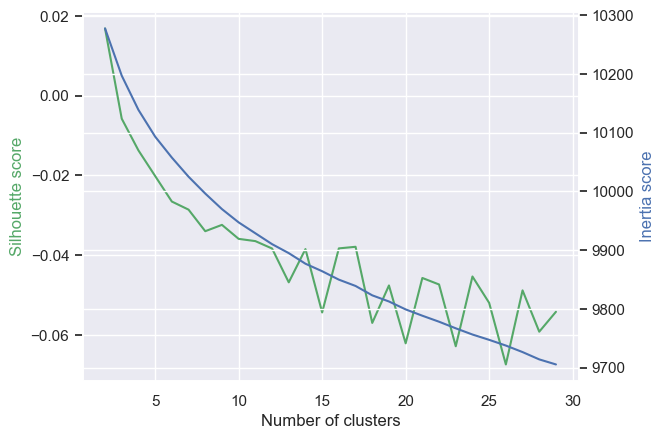

In [279]:
# plt.figure(figsize=(10,6))
# plt.plot(range(2, 30, 1), silhouette_list);
# plt.plot(range(2, 30, 1), Sum_of_squared_distances);
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(range(2, 30, 1), silhouette_list, 'g-')
ax2.plot(range(2, 30, 1), Sum_of_squared_distances, 'b-')

ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette score', color='g')
ax2.set_ylabel('Inertia score', color='b')

plt.show()

In [285]:
N_CLUSTER = 14

latent_clusters = cluster_cosine(X_doc_subset, N_CLUSTER)
doc_vec_end = doc_vec_subset.copy()
doc_vec_end['label'] = latent_clusters.labels_.astype(float)
tsne_doc['cluster'] = latent_clusters.labels_.astype(float)

doc_vec_end['label'].value_counts()

2.0     1257
6.0     1187
13.0    1094
11.0     935
5.0      925
12.0     913
10.0     891
0.0      889
1.0      812
8.0      751
3.0      739
4.0      702
7.0      645
9.0      467
Name: label, dtype: int64

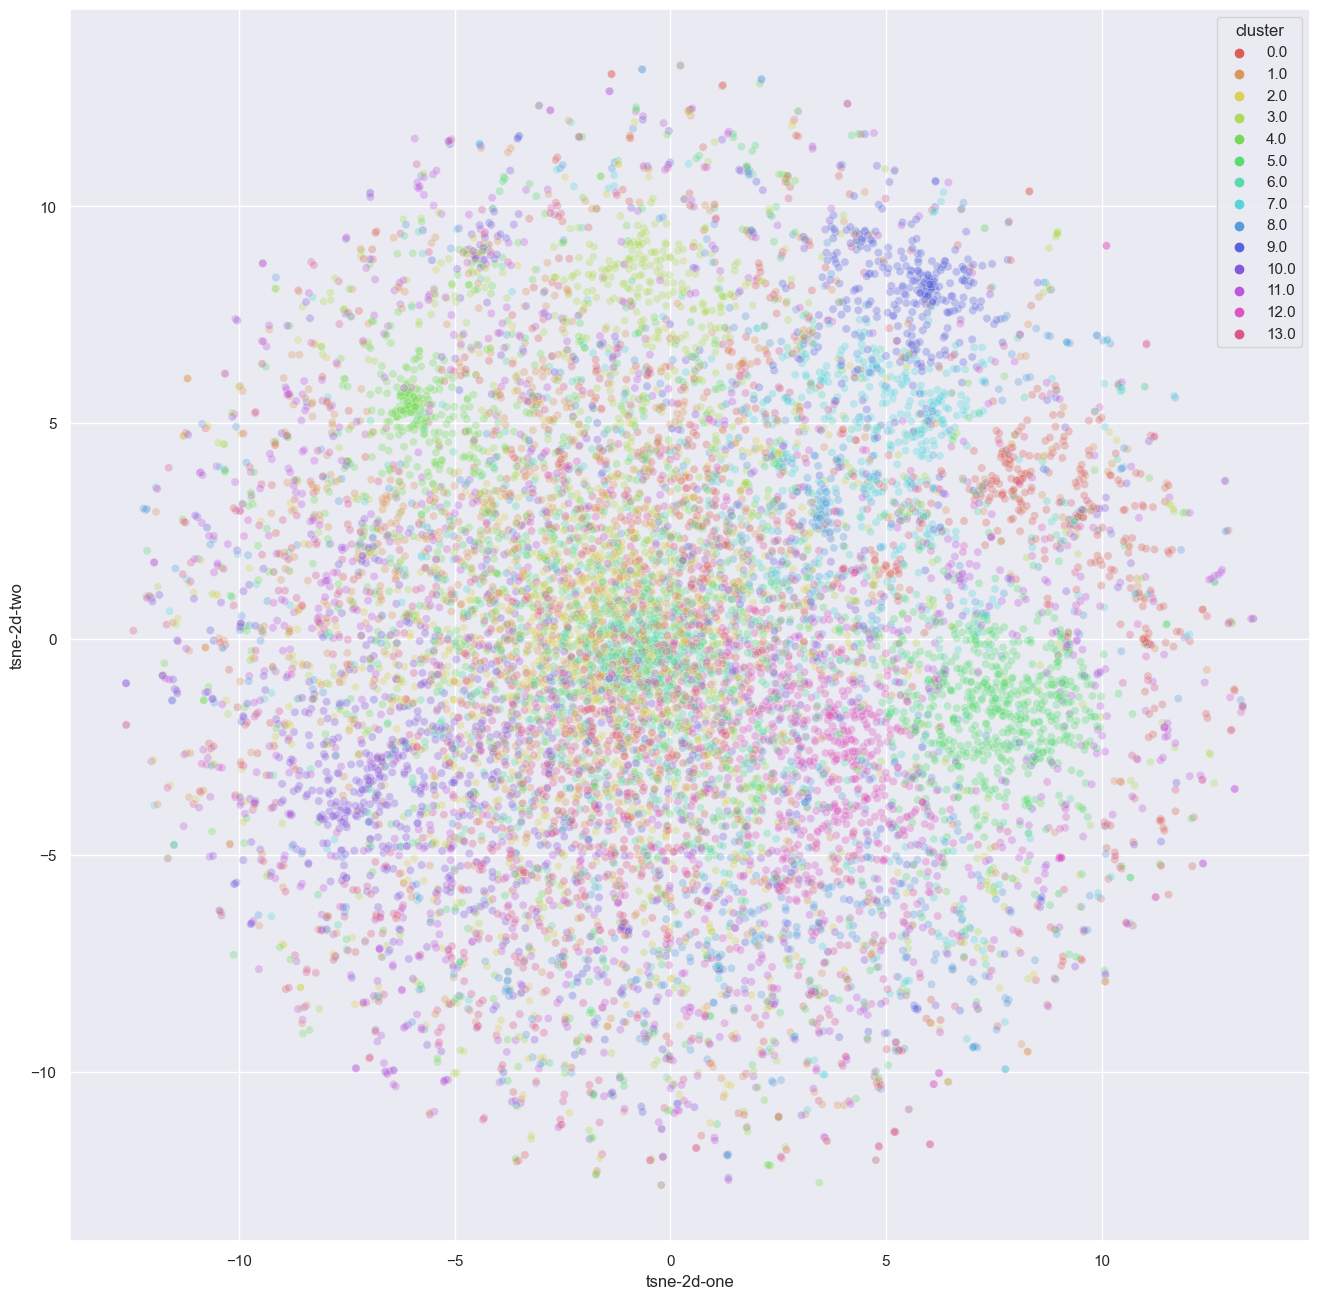

In [286]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();

In [282]:
feature_df['latent_cluster'] = latent_clusters

category_names = np.setdiff1d(prior_orders_details['Category'].unique(), ['other', 'missing'])
interpetation_department = feature_df.groupby('latent_cluster')[category_names].mean()

interpetation_department.T.div(interpetation_department.sum(axis=1)).round(3)

latent_cluster,"KMeans(n_clusters=14, n_init=10)"
Accent & Decors,0.000
Baby Care,0.014
Baby Food,0.004
Beverage & Tobacco,0.046
Commodities,0.062
Consumable Material,0.034
Dairy,0.062
Electronics & Appliances,0.005
Gift & Toys,0.010
HOME MADE,0.001


In [283]:
interpetation_aisle = feature_df.groupby('latent_cluster')[feature_df.columns.values[16:-1]].mean()
interpetation_aisle.T.div(interpetation_aisle.sum(axis=1)).round(3).head(20)

latent_cluster,"KMeans(n_clusters=14, n_init=10)"
Life Style,0.024
Medicine,0.000
Packaged Foods,0.215
Perishables,0.010
Personal Care,0.096
Protein,0.007
Restaurant,0.000
Stationeries,0.004
Vehicle,0.000
Entertainment,0.000


In [288]:
feature_df['latent_cluster'] = latent_clusters.labels_.astype(float)
prior_orders_details_clustered = prior_orders_details.copy()
prior_orders_details_clustered = prior_orders_details_clustered.merge(feature_df['latent_cluster'], on='CustomerCode', how='left')

for cluster_id in range(12):
    prior_orders_details_clustered[prior_orders_details_clustered['latent_cluster']==cluster_id][['CustomerCode', 'ProductName']].groupby("CustomerCode").apply(lambda order: ' > '.join(order['ProductName'])).reset_index().head(20)

,CustomerCode,0
0,3260023,Trix Liquid - 500 ml Lemon > Aftab Chicken Nuggets 250g > Layerr Wottagirl Heaven Body Spray 135ml > Cyprina Grape Juice 1 ltr > S201047 Kitchen Towel > Golden Harvest Dal Puri 454gm (10 Pcs) > Harvest Rich Chiken Sausage 340g > Pran Mega Loly Pop 120g 15pcs > BRAC Chicken Salami Slice 200Gm > E.F Fried Fish Ball 500g > Super Refined Naphthalene(12 Pcs Pack) > Cadbury Bourn Vita Jar 500g > Orchid Air Freshener Beli Aromatic 50g > Haiko Cocoa Powder 30gm > Richi Chicken Samucha 10 pcs > BTM C...
1,3260127,CP Spicy Chicken Ball 500gm > BRAC Chicken Kids Nuggets 250gm > MARKS FULL CREAM MILK POWDER 1000gm > La Vache Quirit Cheese 24 Portions > Golden Harvest SB Chicken Samosa 500gm > CP Spicy Chicken Ball 500gm > Golden Harvest Mini Singara 600g (40pcs) > Golden Harvest SB Chicken Samosa 500gm > PROTIVA Posto Dana (Poppy Seed) 25Gm > Shwapno Jayfal (Nutmeg) 50gm > Aarong white Curd 500 ml > Tilda Pure Basmati Rice 2 Kg > Danish Doreo Blackchoc Sandwich 140g > Romania Lexus Vegetable Cracks 252±...
2,3260193,Himalaya Aloe Vera Face Wash 50ml > S200478 Raping Paper > S201047 Glass Tumler > X-Queens Plain Sugar Bun 4 Pcs 150±15g > Vim Dish Wash Bar 325±25g > BD Food Toast Biscuits 300±50g > X-Queens Raisin Sesame Roll 320g
3,3260365,Ahmed Tomato Ketchup 1000gm > Ahmed Cornflour 150gm > Meridian Sweetened Chili Sauce 285 gm > Aftab Chicken Nuggets 250g > Crown Mayonnaise 473 gm > Ahmed Corn Flour 250 gm > Knorr C.&Thai Soup With F.Container Free > Nivea Dry Comfort Roll On 50ml > Dano Power Full Cream Milk Powder 500g > Haiko Baking Powder (pot) 250 gm > Well Food Special Lachacha Semai 200gm > J.M Bason 500 gm > Golden Harvest SB Chicken Samosa 500gm > BTM Yeast 30g > Knorr Chicken Soup With F.Container Free > Suree Sw...
4,3260418,Kolson Macaroni 400 gm > Bisk Club(Pran) Fit Crackers MFB 130±5g > Camel Wasabi Coated Green peas130gm > Lavender Multigrain Bread 500gm > Swarna Rice Bran Oil 5 Ltr(HDPE) > B.dhara Toilet Tissue (White) > K.Rogers Pineapple Jam Cookies 125g > Aftab Tandori Chicken Nuggets 250 gm > Pran Premium Orange Jelly 250 gm > Aftab Tandori Chicken Nuggets 250 gm > Amul Cheese Slices 200g > Aftab Chicken Burger Pattie 500 gm > Pran Premium Orange Jelly 250 gm > Aftab Chicken Burger Pattie 500 gm > Horl...
5,3260626,Pepsi Diet 500ml (Pet) > Teer Atta 2Kg > Sun Chips Garlic & Chilli 80 gm > IXL Strawberry Conserve 500g > Teer Maida 2Kg > Teer Soyabean Oil 5ltr > Kurkure Chilli Chatka Crackers 50±5g > Shwapno Super Miniket Family Pack 19.5Kg > Nido Fortigrow F.C.I.M.P 700g (BIB) > Harvest Rich Chicken Sausage 250g > PRAN motor Bhaja 30gm > Lavender Bread 300 gm > Sun Chips Mix Masala 80 gm > Kurkure Chilli Chatka Crackers 50±5g > Pran Hot Tomato Sauce Pet 1kg > Nido Fortigrow F.C.I.M.P 700g (BIB) > Pran S...
6,3260645,KFK Spicy Chicken Sausages 340g > Fresh Premium Tea 400 gm > MagicTime Light Mayonnaise 887ml > Nestle Koko Krunch Chocolate Flv. 330g > KFK Dal Puri 450g > S201047 Welburg COTTON BUDS (WOOD) > Aarong Dairy Borhani 1Ltr > Shaad Fine Maida 2kg > J.M Bason 500 gm > ACI Pure Salt 1kg > Bloop Exotic Chocolate 110ml > Rin Power White Detergnt Powder 900±100g > Surf Excel 500g (New) > Lifebuoy Care Soap 150g > Lux Jasmin&Vitamin-E Soap 150g > Shwapno Premium Dabli Dal 1kg > Shwapno Premium Chola 1...
7,3261166,Freedom Super D.Wings 6H.F.+ 4R.F.(COMBO > Freedom Super Dry Heavy Flo.wings 8 pads > Dove Hair Therapy H.F.R Shampoo 700ml > Lifebuoy Hand Wash Pump 200ml(20tk Off) > ORAL-B T.B Bacteria Fighter C.Defense M > Whisper Maxi Fit Wings 15Pads > Temmy`s Choco Scoops 250g > Foster Clark Inst. Drink Lemon 750g Jar > Temmy`s Choco Scoops 250g > Foster Clark Inst. Drink Lemon 750g Jar > BiskClub Europa Sandw Biscuit Orange 80g > Nestle Milo Breakfast Cereal 170g > BiskClub Europa Sandw Biscuit Orang...
8,3261176,Dano Slim Non Fat Milk Powder BIB 350g > Tipco Aloe vera Juice 1 Ltr. > ELIT Milk Chocolate 40±4g > Pringles P.Chips Pizza Flavored 158g US > Harpic Flushmatic - 50 gm > Ceres Cr

,CustomerCode,0
0,3260206,Kwality Half Ltr. Container Strawberry > Goodmeal Kewra Water 200ml > Kwality Half Ltr. Container Strawberry > X-Red Amaranth (Lal Shak) PCS > Fulcopy (P) Pcs > X-Red Amaranth (Lal Shak) PCS > Fulcopy (P) Pcs > Mushroom 100g (P) PolyPack > Mushroom 100g (P) PolyPack > MAGGI 2 Minute Noodles Masala 744gm > MAGGI 2 Minute Noodles Masala 744gm > Goodmeal Kewra Water 200ml > Shwapno Kismis(Raisins)200gm > Shwapno Kismis(Raisins)200gm > Trix Liquid - 500 ml Lemon > Glade Touch & Fresh Lemon Refil...
1,3260294,RFC Koli Pitha 6Pcs Box > M&M Choco Chocolate 45g > Bounty Double 57gm > Mars & Snickers Chocolate Family PackBig > Kinder Country Choco Box 211.5g > Cyprina Guava Juice 1Litre > Cyprina NaturalMangoOrange&AppleJuice1Lt > Mars & Snickers Chocolate Family PackBig > Kinder Joy 20gm > Bounty Choclate Joy Pack 3X Save tk-30/- > Darda Popcorn Super Mix 45g > Lays Stax Sour Cream & Onion 155.9g > Tong Garden Salted Cashew Nuts 180±20Gm > Darda Butter&Cheese Pop Corn 40g(Cup) > Lays Stax Original 1...
2,3260589,Maggi 2MN curry ndls 248gm (FamilyPack) > Kurkure Chilli Chatka Crackers 100±10g > Maggi 2MN curry ndls 248gm (FamilyPack) > Sundrop Mango Fruit Drink Juice 250ml > Hot Breads White Bread 325g > pran frooto 250ml Juice > Hot Breads White Bread 325g > Sundrop Mango Fruit Drink Juice 250ml > Knorr Chicken Sizzler Inst.Noodles 65g > pran frooto 250ml Juice > Knorr Chicken Sizzler Inst.Noodles 65g > Teer Soyabean Oil 2ltr > Frutika Mango 250 ml > Teer Soyabean Oil 2ltr > Frutika Mango 250 ml > B...
3,3260907,J.M Special Badam Bhaja 200gm > J.M Special Chira Bhaja 200gm > J.M Special Jhuri Bhaja 400gm > Doux Chicken Franks Original 340gm > J.M Special Dal(Mug) Bhaja 200gm > KFK Chicken Samosa 250g > Dan Cake Swiss Roll 300g (Box) > Cadbury Dairy Milk Silk Cholate 160±10g > Nestle Kit Kat Chocolate 41.5±5g > Nestle Kitkat Senses Dark 37.3g(IMP) > Snickers Single 50g > Jhatpot Mini Chicken Samosa 250g (25Pcs) > Doux Chicken Franks Original 340gm > Jhatpat Aloo Puri 454g(10 Pcs) > Jhatpat Dal Puri 4...
4,3261087,KFK Kids Chicken Nuggets 250g > KFK Plain Paratha 325g > Bellycious Wheat Atta Rooti Special 10Pc > Mehran Kernal Gold Basmoti Rice 2 kg > PROTIVA Alu Bokhara 50gm > Haiko Cocoa Powder 100g > PROTIVA Alu Bokhara 50gm > J.M.F Rice Flour 1 Kg > Olympic Twinkle Strawberry & Vanilla 72g > Haiko Cocoa Powder 100g > Olympic Twinkle Strawberry & Vanilla 72g > PRAN Premium Ghee 100gm > Lifebuoy Lemon Fresh 100g > Dreem Orange Colour 28ml > Lifebuoy Lemon Fresh 100g > J.M.F Rice Flour 1 Kg > J.M Spec...
5,3261803,"PVC Bag Large (Shwapno Printed)-22""X18"" > Non Woven Tissue Bag(H-24,W-13,F-6)50GSM > Maggi 2MN Masala Noodles 496 gm > S200476 Kiam Karai with Glass Lid 26 cm > Munchys C.Munch O.Chocolate Biscuits 60g > Nestle Kitkat Chocolate 36.5g IND > Nestle KitKat Chocolate 27.5g > Munchys C.Munch D.Chocolate Biscuits 60g > Nestle Classic Chocolate (36±2)g > Danish Nutri Rich Diabetic Biscuits 70g > Globe Britle Biscuits 63±8g > Nestle KitKat C.Chips Chocolate 19.5g > Munchys Oat Krunch Straw.&Blackc.5..."
6,10005399,"Jhatpot Chicken Nuggets 300g (20 Pcs) > Aarong Liquid Milk 500 ml > Thai Choice Spring R.Dipping Sauce 190g > Fu-Wang Noodles Bonus Pack 260g > Bellissimo Premium Choc. Paper Cup 100ml > Golden Harvest Deshi Paratha 650g > Pran Boroi Sweet Pickle- 350 gm > X-Lemon Round (Lebu Gol) PCS > Masafi Orange Juice 1 Ltr > Mama Chicken Flav.Cup Noodles 62g > Horlicks 200gm Jar > Non Woven Tissue Bag(H-24,W-13,F-6)50GSM > Seylon Gold Blend Tea Bag 100g > Marks Young Star F.C Milk Powder 400g > Mac Cof..."
7,10006346,"Brooke Bond Taaza Danedar Tea 400g > Nescafe Classic coffee 50gm (Glass btl) > Rok Dish Wash Steel Scourer 1 Pcs > Sunsilk Stunning Black Shine Shampo 180m > PVC Bag Large (Shwapno Printed)-22""X18"" > Bombay Sweets Alooz Spanish Tomato 25±3g > Danish Toast Biscuits 250g > Munchys Captain Munch O.Chocolate 180g > Sun Chips Wasabi 38 gm > Dark Fantasy Biscuit 75g(Buy2 Get1 Free) > Diploma -I F

,CustomerCode,0
0,3260030,Protiva Died Grapes (Kismis) 100g > J.M. Special Kacha Chips 200gm > Vaseline Intens. Care Deep Restore 400ml > S201047 Lusne(Radhuni)-4Pcs > Pakistani Cone Mehedi 35g > Kolson Corn Flakes 150g > ligion henna box ( big) 100 gm > She Love Body Spray 150ml > PROTIVA Bit Salt 100Gm Pack > ORAL-B T.B Bacteria Fighter C.Defense M
1,3260138,IFAD Eggy Instant Noodles Chicken 65Gm > Maggi 2MN masala noodles 62 gm > FUN Potato Crackers Spicy Tomato 20g > Vim Dish Wash Bar 125g > Horlicks Chocolate Flavour 200g (BIB) > Maggi 2MN curry noodles 62 gm > PRAN Mr. Noodles Easy Magic Masala 62gm > Harvest Rich Dal Puri(10pcs)400gm > IFAD Eggy Instant Noodles Masala 65Gm > Fair & Lovely A. M.Vitamin Face Wash 50g > Tat Macaroni Penne Rigate 500g > Harpic Power Plus 500 ML > Ruchi Chananchur Hot 170 gm > Harpic Power Plus 500 ML > Fay Faci...
2,3260303,S201011 Happy Birthday Ben 10 CNL 1/6 > S201011 Party Spray Cragy Ribbon-PS1/2 > S201011 Birthday Jhorna Candle6P2/6 > Laziza Sindhi Biryani Masala 130g > Pran Borhani Mix 50g > Polar Crunchy > Bloop Squeezy Jazz Ice Cream 105ml > Polar Carnival Cone > Dan Cake Swiss Roll 300g (Box) > Blue Lady 2 Pour Deo.Body Spray 200ml > Rexona Passion Roll On 50ml PHL > Nivea Lip Care Strawberry 2.4g > Organic Harvest Neem Face Wash 50g > Pran All Time Chocolate Cake 100+/-5g > Alif Baking Powder - Paper...
3,3260325,Rupchanda Soyabean Oil 5ltr > Nutri Rich Diabetic Biscuits 210g > Danish IFC Milk Powder 500gm (Poly) > Olympic Nutty Peanut Biscuits 50±5g > Kelloggs Cornflakes Vegetarian 275g > S201047 STEEL EGG SLICHER > Pran Chanachur 150g > X-Relish Kachki Dry Fish 125g > Relish Churi Dry Fish 125g > Relish Loytta Dry Fish 125g (Big) > Mamswad Shole Shutki 125g > ACI Pure Suji(Laminated Pack)500 gm > Maggi 2MN curry ndls 248gm (FamilyPack) > Marks Milk powder 400gm > Nido Fortigrow FCMP Tin 2.5kg > Te...
4,3260343,J.M Special Dal(Mug) Bhaja 200gm > Protiva Chinese 200gm > Satej Coconut Naru 200g > Bebem 4Maxi(7-18kg) 32Pcs > J.M Special Dal(Mug) Bhaja 200gm > Protiva Chinese 200gm > Satej Coconut Naru 200g > Bebem 4Maxi(7-18kg) 32Pcs > Golden Harvest Dal Puri 454gm (10 Pcs) > Aftab Tandori Chicken Nuggets 250 gm > Jhatpat Veg.Singara 400g 10Pcs > Aftab Tandori Chicken Nuggets 250 gm > Golden Harvest Dal Puri 454gm (10 Pcs) > Aftab Chicken Burger Pattie 500 gm > Jhatpat Veg.Singara 400g 10Pcs > Aftab C...
5,3260409,Kazi & Kazi Tulsi Tea Bag 60 gm > Bisk Club Fit Crackers Milk Flv 70g > Kazi & Kazi Tulsi Tea Bag 60 gm > Bisk Club Fit Crackers Milk Flv 70g > Trix Liquid - 250 ml Mint > B.dhara Toilet Tiss Lemon White Perfumed > Trix Liquid - 250 ml Mint > B.dhara Toilet Tiss Lemon White Perfumed > BLUE For Men Deo.B/Spray 200ml > Prodental B New Junior Toothbrush 1pc > BLUE For Men Deo.B/Spray 200ml > Prodental B New Junior Toothbrush 1pc > Olympic Twinkle Strawberry & Vanilla 72g > Sewha Hi-Speedy Color...
6,3260466,S201409 STABILO conqueror Eraser 1193C > La Vache Quirit Cheese 8 Portions > Nawar Sun Flower Margarine 250g > Pran Premium Butter 100g > Shwapno Premium Deshi Chini 1kg > Farmasi P.Herbal Dry Hair Shampoo 700ml > Rupchanda Soyabean Oil 1 ltr (Pouch) > Bashundhara Atta 2 Kg > Flormar Face Compact Powder Wet & Dry > Kolson Vermicelli 200 gm > Flormar Face Compact Powder Wet & Dry > Bashundhara Atta 2 Kg > Kolson Vermicelli 200 gm > Moghal Shahi sour Curd 600g > Moghal Shahi sour Curd 600g >...
7,3260503,Golden Rose Liquid P.M.Foundation 35ml > Ponds Age Miracle W.Cor. Day Cream 50ml > English Blazer Men Gold Body Spray 150ml > Ponds Age Miracle W.Cor. Day Cream 50ml > H&S Men Hair Retain Shampoo 610ml > Vaseline T.M. Cocoa Glow B.Lotion 400ml > English Blazer Men Gold Body Spray 150ml > Vaseline T.M. Cocoa Glow B.Lotion 400ml > Golden Rose Liquid P.M.Foundation 35ml > Ponds Age Miracle D.A. Night Cream 50ml > H&S Men Hair Retain Shampoo 610ml > Ponds Age Miracle D.A. Night Cream 50ml > Nive...
8,3260564,Brooke Bond Taaza Danedar Tea 400g > Golden Harvest Dal Puri 454gm (10

,CustomerCode,0
0,3074467,MARS Single 51g > CADBURY Dairy Milk Fruit&Nut 200gm (U.K) > ELIT Dark Bitter Chocolate 40±4gm > Maggi 2MN masala noodles 62 gm > Snickers Single 50g > Elite Truffle Gourmet Collection 43gm > Cadbury Dairy Milk Shots 16.2±3.5g > Nestle Kit Kat 45Gm > Snickers Power P.Chocolate Save tk-40/- > Nestle Coffee Mate 450 gm BIB > Foxs Crystal Clear Fruits 90 gm Bag > Cute Perfu.Coconut Lite Hair Oil 330ml > Olympic First Choice Salted Biscuits 80g > Haque Mr.Cookie B.Coconut Biscuits 80±5g > Olym...
1,3260104,MAGGI Shaad E Magic 1 pcs > Radhuni Cumin 50 gm > ACI Pure Salt 1kg > Kolson Vermicelli 200 gm > Pran Turmeric 200 gm > Bombay Chanchur 150g > Mediplus DS Gentle Whitening 140gm > Pran Chilli Powder- 200 gm > Vim Dish Wash Bar 325±25g > Pran Lacha Shemai 200 gm > PRAN Mr. Noodles Easy Magic Masala 496gm > S201143 Trousers Soft Small > Seylon Gold Blend Tea Bag 100g > Odonil Mystic Rose Air Freshner50g(Hang) > Pran Lacha Shemai 200 gm > Surf Excel 500gm 2pcs 40Tk. off > Harpic Power Plus 750 ...
2,3260174,Gold Mark Original F.Cookie Biscuit 115g > Radhuni Easy Mix Rezala Masala 38gm > dettol skin care soap - 75 gm > Radhuni Easy Mix Rezala Masala 38gm > Gold Mark Original F.Cookie Biscuit 115g > Veola Soyabean Oil 5Ltr. > Best`s Chili Sauce 340 gm > dettol skin care soap - 75 gm > Best`s Chili Sauce 340 gm > Veola Soyabean Oil 5Ltr. > Meril Rose Water Glycerine 120g > Pran Pineapple Cream Biscuit 100gm > Meril Rose Water Glycerine 120g > Pran Pineapple Cream Biscuit 100gm > Cute Petrolium...
3,3260434,S201384 FABER CASTEL COLORPENCIL PP 12 > Fresh Sugarcane Juice 500ml > ACI Pure Kheer Mix 150g(Buy2 Get1 Free) > Snickers Fun Size 18gm > X-Queens Doughtnut Sugar 5Pcs 200g > X-Queens Burger Bun 4 Pcs 250±15g > Arko Men Shaving Gel Sensitive 75ml > KIWI Express Inst Shine Sponse Black 7ml > Shwapno Premium Dabli Dal 1kg > Shan Chaat Masala 100g > JMF Special Fushka 200g > Haiko Bit Salt (bottle) 80 gm > JMF Special Fushka 100g > Oitijja Jurivaja 300g > Olympic Crack Jack 70 gm > Nestle KitKa...
4,3260692,S201260 Ben10 Plastic Ball > Meiji H.P Biscuits Strawberry Flv 50g > S201384 CD Dart Board Game > Kinder Joy 20gm > M&M Peanut 45Gm > Cadbary Oreo Original 150g > X-S200517 Many Kur Pady Kur Set C-9014 > Wheel Lemon Power Detergent Powder 1 kg > Nestle Nido Forti Grow BIB 350g > Wheel Lemon Power Detergent Powder 1 kg > Surf Excel 500g (New) > Bombay Sweets Alooz Magic Masala 25±3g > Nestle Nido Forti Grow BIB 350g > Bombay Sweets Alooz Magic Masala 25±3g > Surf Excel 500g (New) > MARKS FULL...
5,3261026,Bisk Club Fit Masala Flv.70g > Sunfeast D.C Strawberry &Vanilla 150±30g > Ifad Sweet & Salty Biscuit 65g > PROTIVA Peanut (Fried) 200gm > Satej Badam Papri 1 Pcs > Bisk Club Stick Biscuit 60g > Haque Chocolate Digestive Biscuits 145g > ROMANIA Milk Protein 45(±5)Gm > Gold Mark Fruti Orange Biscuit 75g > Bisk Club Fit Masala Flv.70g > Olympic Twinkle Twinkle Ora.&Vanilla 72g > Lifebuoy Mild Care H.Wash 180±10ml Refil > Satej Fried White Peanut 100g > Ifad Tea Time Biscuit (150±30g) > Teer Mai...
6,3261093,"Doreo BlackChocSandwichCrem Biscuit 320g > Ifad Dry Cake 300g > Haque Sooper Creamy Choc Biscuit 105gm > Olympic Nutty Peanut Biscuits 50±5g > NonWoven Tissue Bag Large (18""X15"") > Danish Toast Biscuits 250g > Meril Soap Bundle Offer(Save tk-20/-) > CBL Munchee Milkaas Biscuits 60g > Ovaltine Malted Chocolate Drink 400g > Danish Max Milk Biscuits 70g > ACI Pure Soyabean Oil 5 ltr > COCOLA Champion Choco.Cream Biscuit 75g > Bisk Club Fit Masala Flv.70g > Olimpic E.Plus Biscuits Malai Cream 45..."
7,3261178,Cadbury Oreo Orange Crème 150g > Well Food Garlic toast Biscuits 200gm > Satej Til Tana 80g (1pcs) > BD Tamarind Chutney 500 gm > Cadbary Oreo Original 150g > BD Food Toast Biscuits 300±50g > Aftab Chicken Nuggets 250g > Romania Lexus Vegetable Tin 630±20g > Olympic Nutty Peanut Biscuits 50±5g > K.Rogers S.Free Cumin Seed Cookies 105g > Pran Chalta Pickle 400g > Senora sanitary napkin eco (belt) 15 pad 

,CustomerCode,0
0,3260080,Cadbury Fruit & Nut 49GM(U.K) > Linco Standard Silicone Nipple(All Size) > Glinter Soft Drink Lychee 350ml (Can) > Linco Round-Hole W Neck Nipple (L-22208) > Dano Power Full Cream Milk Powder 500g > X-S201165 Kids Girls -2 > F&N 100Plus Original Drink Can 325ml > S201165 Baby Handkerchief > SweetZone Mallow Twists 190±20g > X-S201165 Kids Girls -7 > S201165 Kids Girls -3 > S201165 Towel Belbet 27/54 > X-S201343 L.Gold.Black SleperWEVG201003-36 > Cadbury Dairy Milk Silk Chocolate 60±5g > S201...
1,3260123,Shakti Mango Doi 80gm > J.M.F Special Shon Papri Box 200g > Kinder Joy 20gm > Ulker Kalbim Vegetable Margarine 500g > Protiva Jhuri Vaza 200gm > Protiva Coconut Chira 50g > English Antilice Shampoo 125ml > Cyprina Orange Juice 250ml > Kinder Joy 20gm > OKF Sac`s Strawberry Drink 240ml > RD Strawberry Milk UHT 200ml > Frufarm Strawberry Juice 240ml Can > Kellogs Apple Jacks Cereal 345g > ACT II Xtreme Butter Flv Popcorn 70g > Tamek 100% Peach Apple Juice 1Ltr > Gold Mark Borfi Biscuits Jar 65...
2,3260236,Olympic Tasty Milk Candy 50pcs (125gm) > Pran Mr.Noodles Beef Flv 310g (5 Pkt) > S201362 Colorful Caterpillar > TicTac Orange 13gm > Sundrop Mango Fruit Drink Juice 250ml > Cadbury Oreo Choco Sandwich 127.4±27.4g > B.dhara Toilet Tissue (Gold) > Pran Mama Milk Wafer 18 gm > PRAN Choco Bean 40Gm (Tube) > B.dhara Facial Tissue 150 PcsX2Ply White > Dellos Peach Juice 240ml (Can) > Pepsodent E.P Pro-Sensitive T.Paste 100g > Pran Chinigura Rice 1Kg > Aarong white Curd 500 ml > Radhuni Garam Masal...
3,3261344,Nescafe Classic coffee 50gm (Glass btl) > Brooke Bond Taaza Danedar Tea 200g > Nestle Munch Rollz 6g > X-Red Amaranth (Lal Shak) PCS > Broccoli (P) (Pcs) > Pran Tomato Ketchup 1000 gm > Rin Power White Detergnt Powder 900±100g > ACI Pure Atta 1 kg > Rin Power White Detergnt Powder 900±100g > ACI Pure Atta 1 kg > My Thai Soup 35g > Doodles Stick Noodles 300g > My Thai Soup 35g > Doodles Stick Noodles 300g > Indian Spinach (Palong Shak) PCS > MARKS FULL CREAM MILK POWDER 500gm > Indian Spinach...
4,3261499,"Complan Chocolate Flavour 350g BIB > Aarong Liquid Milk 1000 ml > Cadbury Dairy Milk Chocolate(16±2.8)g > Gandour Safari Chocolate (15±3)g > Ruchi Dal Bhaja 30 gm > ACI Hi Booster Jumbo Coil 12hour > Mr. Brasso GC - 350 ml Spray > B.dhara Paper Napkin 13""x1ply 100pcs (W) > Rok Floor Cleaner Lemon 500ml > J.M Special Chira Bhaja 200gm > IFAD Kaju Delight Biscuit 60Gm > J.M Special Chira Bhaja 200gm > IFAD Kaju Delight Biscuit 60Gm > MAGGI 2 Minute Noodles Masala 744gm > Bombay Sweets Dalmoth ..."
5,3261763,PROTIVA Kismis (Died Grapes) 200Gm > ORAL-B Crisscross Medium > PRAN Mr. Noodles Easy Magic Masala 496gm > Radhuni Shemai 200gm > Finis Insect Powder 40 gm > I.D Glitter Eye Liner 5ml # Ge01 > Cocola Cook Chicken Tanduri 400g > PROTIVA Pestabadam (Pistachio) 50Gm > Angelic Airfreshener Misty Wood 300ml > Jackelin Nail Polish All Color 14ml > Jhatpat Deshi Paratha 1300g(20Pcs) > Well Food Special Lachcha Semai 400gm > Shan Tandoori Masala 50g > S201047 Kitchen Apron > PROTIVA Kath Badam (Almo...
6,3261802,Kiddo custurd (Strawberry)25 gm > Dan Cake Chocolate Muffin 30g > Mutton Brain (Pcs) > S201141 Past Gawn-38 > Well Food Chocolate Loaf Bun 200g > Olympic Twinkle Strawberry & Vanilla 72g > Olympic Tip Crispy Salted Biscuits 70g > Shwapno Premium Nazirshail Rice 19.5Kg > Kurkure Corn Balls Crazy Herb Chips 37g > Shwapno Premium Chola 1 Kg > Gizo Umbrella Chot.&Orange Cream 21±3g > Shezan CC.Chocolate(B330g G150g CF Free) > S201400 R/C Racing > S201384 Sofia Doll 552 > Kinder Joy 20gm > Vim Di...
7,3262001,Igloo Sweet Curd 500g > Harvest Rich Beef Meat Ball 300g > Golden Harvest SB Beef Samosa 250gm > Golden H. Beef Spring Roll 300g 15pcs > Golden Harvest Mini Singara 600g (40pcs) > Teer Atta 2Kg > 100%Stainless steel Tea Strainer (Big) > Protiva Died Grapes (Kismis) 100g > Kinder Joy 20gm > Savlon Liquid Antiseptic 1000ml > ACI Pure Salt 1kg > Shwapno Super Miniket Family Pack 19.5Kg > Saffola Activ

,CustomerCode,0
0,3260223,Bashundhara Brown Atta 1kg > Sajeeb Atta 2 Kg > Bashundhara Brown Atta 1kg > Sajeeb Atta 2 Kg > Olympic First Choice Salted Biscuits 80g > Radhuni Haleem Mix 200 gm > Olympic First Choice Salted Biscuits 80g > Radhuni Haleem Mix 200 gm > Sajeeb Maida 2 Kg > Harvest Rich Plain Paratha 650g (10 Pcs) > Sajeeb Maida 2 Kg > Harvest Rich Plain Paratha 650g (10 Pcs) > Sajeeb Suji 500g > Sajeeb Suji 500g > Bashundhara Maida 2 Kg > Maggi C.Noodles 260g(Buy2 Get1 Free) > Bashundhara Atta 2 Kg > Close ...
1,3260324,Aarong Liquid Milk 1000 ml > Pran Mr.Noodles Beef Flv 310g (5 Pkt) > ACI Pure Vermicelli 200 gm > Farm Egg Brown 6Pcs Box > Aci Pure Halim Mix 200 gm > FUN Potato Crackers Spicy Tomato 20g > Nestle Koko Krunch Chocolate Flv. 330g > Olympic Daily Toast 300g > Aci Pure Halim Mix 200 gm > Olympic Daily Toast 300g > Nestle Koko Krunch Chocolate Flv. 330g > Lux Soap Purple Lotus 100g > Pran Good Life Vegetable Ghee 200g > Lux Soap Purple Lotus 100g > FUN Potato Crackers Spicy Tomato 20g > Pran Go...
2,3260403,Rupchanda Mustard Oil 200 ml Pet btl > Shwapno Premium Chola 1 Kg > ACI Pure Atta(Laminated Pack)2 kg > Shwapno Premium Nazirshail Rice 19.5Kg > Shwapno Mixed Dal 1Kg > PRAN Mr. Noodles Easy Magic Masala 496gm > Bangla Paper Napkin (80 Sheet/Pack) > Pran Chocolate Flavored Milk Pouch 200ml > Akher Chini 1Kg > Mumtaz Glycerine Alovera 140g(BOGOF) > Bangla Paper Napkin (80 Sheet/Pack) > Pran Chocolate Flavored Milk Pouch 200ml > Wheel Laundry Soap 125g > Mumtaz Glycerine Alovera 140g(BOGOF) ...
3,3260816,"Indian Spinach (Palong Shak) PCS > PVC Bag Large (Shwapno Printed)-22""X18"" > X-Red Amaranth (Lal Shak) PCS > Farm Egg Brown Loose(Pcs) > Bellissimo Primo Choc.Ice Cream 70ml > Knorr Ins. Noodles Chicken Sizzler 520g > ACI Pure Atta(Laminated Pack)2 kg > PVC Bag Large (Shwapno Printed)-22""X18"" > Bellissimo Primo Choc.Ice Cream 70ml > Knorr Ins. Noodles Chicken Sizzler 520g > ACI Pure Atta(Laminated Pack)2 kg > PVC Bag Large (Shwapno Printed)-22""X18"" > CP Chicken HOT Sausage 400 gm > Bashundha..."
4,3261208,Golden Harvest French Fries 500gm > Golden Harvest French Fries 500gm > Golden Harvest SB Chicken Samosa 500gm > Golden Harvest SB Chicken Samosa 500gm > Bengal Meat Chicken Meat Ball 360g > Bengal Meat Chicken Meat Ball 360g > Brac Chicken Kebab 500gm > Brac Chicken Kebab 500gm > BRAC Chicken Meat Ball 250Gm > BRAC Chicken Meat Ball 250Gm > Golden H. Beef Spring Roll 300g 15pcs > Golden H. Beef Spring Roll 300g 15pcs > KFK Kids Chicken Nuggets 250g > Harvest Rich Chicken Meat Ball 300g > KF...
5,3261328,Coca Cola 2.25 Ltr. pet > Sajeeb Atta 2 Kg > Igloo Sweet Curd 500g > 7 Up Pet Bottle 2000ml > Farm Fresh yugurt(Sour)500ml > Lifebuoy Refill Care 180ml off tk-15/- > Shwapno Oven Fresh Butter Naan 250g > Aarong Liquid Milk 1000 ml > ACI Aerosol Insect Spray 800ml > Kazifarms Kitchen Chicken Nuggets 250g > Nestle Milk Cream 160 gm > KFK Plain Paratha 1300g > Finlays Green Tea Bag 100gm(50 bags) > Olympic Black Cream Biscuit 85g > Finlays Green Tea Bag 100gm(50 bags) > Pran Sour Curd 500g > KF...
6,3261477,7 Up Pet Bottle 2000ml > Coca Cola 2.25 Ltr. pet > Nestle Nido 3+G.Up Milk Powder 350g > Ifad Maida 1 Kg > MARS Single 51g > Sajeeb Atta 2 Kg > Kinder Joy 20gm > X-S200055 Unilever Pure It Save tk-1010/- > AG Food Chicken Meatball(23-25)Pcs 250g > Kinder Joy 20gm > Ovaltine Malted Barli Drink 400g > Kinder Joy 20gm > ACI Pure Maida (Lami) 2 Kg > Danish Toast Biscuits 250g > Ovaltine Malted Barli Drink 400g > Danish Toast Biscuits 250g > AG Food Chicken Meatball(23-25)Pcs 250g > Pran All Time...
7,3261540,Nivea B.Spray+Roll On Man Save tk-81/- > Nocilla Chocolate Cream 200g > Nivea B.Spray+Roll On Man Save tk-81/- > X-Coconut (Narikel) PCS > Danish Condensed Milk 397 gm > Nocilla Chocolate Cream 200g > Danish Condensed Milk 397 gm > X-Coconut (Narikel) PCS > Best`s Chili Sauce 340 gm > Ahmed Soy Sauce 500 gm(L) > Best`s Chili Sauce 340 gm > Pran Rose Water 180±10ml > Danish Milk Marie Buiscuit 28

,CustomerCode,0
0,2213257,Diamond Aluminium Foil 37.5 SQ.FT. > E.F Lingo Fish Cake 500g > E.F Fish Tofu Square 500g > S201047 Pata salad cutter
1,3260015,Aafi Chanachur Hot 80g > Pran Mango Fruit Drink Tetra 250ml > Aafi Chanachur Hot 80g > Shakti Mango Doi 80gm > Pran Mango Fruit Drink Tetra 250ml > Shakti Mango Doi 80gm > B.dhara Toilet Tissue (White) > B.dhara Toilet Tissue (White) > Provati Pachforon 50g (Polypack) > Provati Pachforon 50g (Polypack) > Horlicks 200g (BIB) > Horlicks 200g (BIB) > Aarong white Curd 500 ml > Aarong white Curd 500 ml > Provati Pachforon 100g (Poly Pack) > Provati Pachforon 100g (Poly Pack) > Freedom Super Dry ...
2,3260097,Julies Cheese Crackers 600±20g > Kwality 1000 ML Container Double Sundaes > Julies Cheese Crackers 600±20g > Kwality 1000 ML Container Double Sundaes > Cocola Cook Chicken Tanduri 400g > Cadbury Oreo Choco Creame 150g > Cocola Cook Chicken Tanduri 400g > Cadbury Oreo Choco Creame 150g > Britannia Bourbon Original 169±19g > Pran Mr.Noodles Spicy Tomato 310g (5Pkt) > Britannia Bourbon Original 169±19g > Pran Mr.Noodles Spicy Tomato 310g (5Pkt) > IFAD Eggy Instant Noodles Chicken 390Gm > Lavend...
3,3260171,Olympic Milk Plus 55g > Tiger Milk Plus Biscuit 70g > Bombay Chanchur 80(±15)g > Lavender Bread 400 gm > ROMANIA Milk Protein 45(±5)Gm > Tiger Milk Plus Biscuit 70g > Bombay Chanchur 80(±15)g > Lavender Bread 400 gm > Olympic Milk Plus 55g > Romania Munchy Biscuit 40g > Parachute Shubidha Pack CoconutOil 150ml > IFAD Butter Delight Biscuit 60Gm > ROMANIA Milk Protein 45(±5)Gm > Romania Munchy Biscuit 40g > Parachute Shubidha Pack CoconutOil 150ml > Tooth Pick Poly Pack 100 ± 10 Pcs > GoldMar...
4,3260186,BTM Mustard Powder(Rai) 60g > Shwapno SuperPremium Indian Piyaj 2KgPkt > X-Hilsha Medium (0.600 - 0.699 Kg) - R > Aarong white Curd 500 ml > Sandalina Soap 75Gm > B.dhara Toilet Tissue (Gold) > Sandalina Soap 75Gm > Aarong white Curd 500 ml > Lux Soap Purple Lotus 100g > B.dhara Toilet Tissue (Gold) > Lux Soap Purple Lotus 100g > Protiva Died Grapes (Kismis) 100g > Shwapno Premium Whole Chilli 100g > Protiva Died Grapes (Kismis) 100g > Shwapno Premium Whole Chilli 100g > Dabur Vatika En.Coco...
5,3260244,MARS Single 51g > X Pel Aerosol Zero Mosquito F. 250ml > Moghol Shahi Borhani 1500ml > X Pel Aerosol Zero Mosquito F. 250ml > MARS Single 51g > Lamisa Vegetable Mini Singara 450g > Moghol Shahi Borhani 1500ml > Lamisa Vegetable Mini Singara 450g > Snickers Single 50g > Fruita Strawberry Toffee 30g > Lamisa Beef Mini Samosa 400g (40pcs) > Fruita Strawberry Toffee 30g > Snickers Single 50g > Lamisa Paratha 20pcs Family Pack > Lamisa Beef Mini Samosa 400g (40pcs) > Lamisa Paratha 20pcs Family P...
6,3260252,Ruchi Chananchur Hot 170 gm > Igloo Sour Curd 500g > Ruchi Chananchur Hot 170 gm > Igloo Sour Curd 500g > Lavender Bread 300 gm > BTM Cinnamon Powder 40g > Lavender Bread 300 gm > BTM Cinnamon Powder 40g > BiskClub Europa Sandw Biscuit Straw. 80g > Ruchi Barbecue Chanachur 170 gm > BiskClub Europa Sandw Biscuit Straw. 80g > Ruchi Barbecue Chanachur 170 gm > Danish Condensed Milk 397 gm > Sajeeb Isbgul Bhushi 40±5g > Danish Condensed Milk 397 gm > Sajeeb Isbgul Bhushi 40±5g > La Vache Quirit ...
7,3260317,Igloo Premium Mega 82 ml > MARKS FULL CREAM MILK POWDER 1000gm > Polar Carnival Cone > Teer Atta 2Kg > Mama Masala Flavour Noodles 496g > Rupchanda Soyabean Oil 1 ltr (Pouch) > Kolson Egg Noodles 170±10g > Dabur Honey 500 gm > Cadbury 5 Star 22.4g > Aarong Low Fat Milk (500 ml) > Cadbury 5 Star 22.4g > IFAD Choco Delight Biscuit 220g > GoldMark Sp.Choco.Cookies Biscuit 270g > Aarong Low Fat Milk (500 ml) > GoldMark Sp.Choco.Cookies Biscuit 270g > IFAD Choco Delight Biscuit 220g > Farm Egg Br...
8,3260342,Aarong Liquid Milk 1000 ml > AARONG Ghee 400 gm > PROTIVA Posto Dana (Poppy Seed) 25Gm > AARONG Ghee 400 gm > Aarong Liquid Milk 1000 ml > Golden Harvest SB Chicken Samosa 500gm > PROTIVA Posto Dana (Poppy Seed) 25Gm > Golden Harvest SB Chicken Samosa 500gm > Doux Chicken Fra

,CustomerCode,0
0,3260089,Danish FnF Crackers 130g > Chamak Fabric Brightener 100ml > Haque Chocolate Digestive Biscuits 145g > Savlon Aloe Vera Handwash 500ml > Gillette SER GEL MOISTURSING 195Gm > Lens Pure Spices Black Seeds 100g > Lens Pure Spice Almond 50g > S201400 crab. > Sensodyne Rapid Relief Tooth Paste 80g > Harpic Bathroom Cleaner Liquid 500ml > Odofresh U.Shine T.Cleaner 500ml(BOGOF) > Shiny Dishwashing Paste Lemon 200g > Banana(Shobri)Yellow
1,3260179,pran Muri 250 gm > Lifebuoy Mild Care H.Wash 180±10ml Refil > Fay Facial Tissue 160±20x2 Sheet > Horlicks 450 gm BIB > Cyprina Orange Juice 1 ltr > Milk Vita Liquid Milk 1000 Ml > Olympic Nutty Peanut Biscuits 50±5g > Bottle Gourd (Lau) PCS > B.dhara Perfumed Facial Tissue 120PX2Ply > Teer Suji 500gm > Lavender Bread 400 gm > Lavender Nut Cake 200g > Xtra Power Detergent Powder Lemon 500g > Dettol Double Pack Hand Wash Save tk.30/ > Romania Pineapple Cream 85(±5)g > Xtra Power Detergent Powd...
2,3260269,Maggi 2MN masala ndls 248gm (FamilyPack) > Maggi Healthy Soup Vegetable 25 gm > Maggi 2MN masala ndls 248gm (FamilyPack) > Maggi Healthy Soup Vegetable 25 gm > Maggi Healthy Soup Corn w/chicken 25gm > Anchor Fortified IFCM Powder 500gm > Maggi Healthy Soup Corn w/chicken 25gm > Anchor Fortified IFCM Powder 500gm > GoldMark Cho.Chips Cookies Biscuit 140g > Protiva Cinnamon (Darchini) 100g > GoldMark Cho.Chips Cookies Biscuit 140g > Protiva Cinnamon (Darchini) 100g > Romania Lexus Vegetable Cr...
3,3260473,Shwapno Premium Deshi Chini 1kg > Protiva Cardamom (Elach) 50g > Diploma I.F.C.M.P 500g (Foil Pack) > Shwapno Lobongo(Cloves)50gm > Kiswan Sugar Free Biscuit 300g > Snickers Single 50g > Brac Chicken Cutlet 500gm > Aarong white Curd 500 ml > Spondon Rice Brain Oil 5Ltr Pet > Snickers Single 50g > Brooke Bond Taaza Danedar Tea 400g > Golden Harvest SB Chicken Samosa 500gm > Kolson Vermicelli 200 gm > Protiva Cardamom (Elach) 50g > Milk Vita Liquid Milk 1000 Ml > Golden Harvest Mini Singara 30...
4,3260523,Elit Gourmet Col. Ass. Choco. Pink 170g > S200740 Men`s F/S Polo T-Shirt Black-54 > S201205 Mens Shirt-L > Ginnou Chocolate Twist Box 154g > S201541 Lady Leggings Ex. Jeans type > S201327 Lady Multi Clutch Bag > Ginnou Chocolate Box 205g ± 30g > S201556 TOPS GRILS FRONT STONE > S200798 T Shirt > Max Choco Chocolate 62.5g Red (Heart) > S200795 Ladies Jewelry Variety 8 > S200795 Ladies Jewelry Variety 11 > AL-Seedawi Milco Toffee 400g (Pkt) > Max Choco Chocolate 38g Red (Heart) > Mars Minis...
5,3260925,X-Chal Kumra (P) Pcs (Block) > Danish Lexus Vegetable Biscuit 180±60g > Bottle Gourd (Lau) PCS > Lavender Bread 300 gm > X-Red Amaranth (Lal Shak) PCS > Spondon Rice Brain Oil 5Ltr Pet > Shwapno SuperPremium Diamond Alu 3kg Pkt > Cadbury Dairy Milk Fruit & Nut 40±2g > S201411 Men`s Tie Single Multi B > Shwapno Brown Egg (12Pcs) > S201370 Men`s Formal Shirt Multi-2 S16.5 > S200798 Vest Rupa > S201369 Men Cargo Pant MLP-1019 Black-34 > ACI Pure Vermicelli 200 gm > Fresh Refined Sugar 1Kg > Fre...
6,3260942,Amul Cheese Slices 200g > Sajeeb Saya sauce 300ml > Pran Hot Tomato Sauce 340 gm > Aarong white Curd 500 ml > Shan Biryani Masala 50g > Brooke Bond Taaza Danedar Tea 400g > Shan Biryani Masala 50g > Aarong white Curd 500 ml > Danish Florida Orange Biscuits 70±5g > Brooke Bond Taaza Danedar Tea 400g > Danish Florida Orange Biscuits 70±5g > Well Food Noodles 180g > Dabur Vatika Enriched Hair Oil 150g > GoldMark Fruit Papaya Biscuits 80g > Dabur Vatika Enriched Hair Oil 150g > Well Food Noodles...
7,3260976,IFAD Eggy Instant Noodles Chicken 390Gm > Teer Atta 1Kg > Gold Mark Chocket Biscuits Jar 650g > Rexona Men Quantum Roll On 25ml > S201343 L.Silver Brn SleperWALS101005-36 > S201047 Steel scourer > Fay Facial Tissue 160±20x2 Sheet > Hot Breads Burger Bun 2Pcs 180g > Vim Dish Wash Bar 325±25g > Brac Chicken Burger Patties 500gm > Aarong Choco Milk UHT Flav. 250ml > Bengal Meat Beef Burger Patty(6 Pcs)360g > Bega Gourmet Slice 200g > Aarong white Curd 500 ml > Milk Vita L

,CustomerCode,0
0,3260051,"S200798 JMN Mens Woolen Hand Gloves-120 > S200798 JMN Womens Woolen Cap-350 > S200798 JMN Mens Woolen Cap-100 > Fay Facial Tissue 160±20x2 Sheet > Breeders Choice Bird Food B.Seed Mix 1kg > B.dhara Classic P Napkin 15X15X80Pcs > B.dhara Toilet Tissue (White) > Pur Baby Feeding Bottle 50(±10)ml > Dan Cake Chocolate Muffin 30g > Cadbury Dairy Milk Chocolate(5.8±0.5)g > Radhuni Panch Foran 50 gm > X-Banana (Chini Champa Small) PCS > S201254 9.5""LovelyBowl-Lid-92227 > S201047 Kids Scales > Robi..."
1,3260109,MAGGI Shaad E Magic 1 pcs > Nestle KitKat Chocolate 27.5g > Bloop Chocolate Lust 100ml > Nestle KitKat Chocolate 27.5g > Bloop Chocolate Lust 100ml > Golden Harvest SB Chicken Samosa 250gm > Colgate Visible White Mint T.Paste 100g > Golden Harvest SB Chicken Samosa 250gm > Colgate Visible White Mint T.Paste 100g > Bloop Choc-o Papa Stick Ice Cream 72ml > Doux Chicken Franks Original 340gm > Bloop Choc-o Papa Stick Ice Cream 72ml > Doux Chicken Franks Original 340gm > MAGGI Shaad E Magic 1 pc...
2,3260177,Olympic Energy Plus 62±6g > Teer Atta 1Kg > Pran Moshur Dal 1Kg > Globe pineapple Biscuits 90g > Finlays Premium Tea 200gm > Pran Pineapple Cream Biscuit 100gm > Radhuni Mustard Oil 250 ml > Fresh Refined Sugar 1Kg > Fresh Super Premium Salt 1kg > Nestle Munch Rollz 6g > Milk Vita Liquid Milk 500 Ml > Wonder Dish Wash Bar 100g > Wheel Lemon Power Detergent Powder 500g > Milk Vita Liquid Milk 500 Ml > IFAD Choco Delight Biscuit 60Gm > Fire Box (12 Box) > ACI Pure Atta 1 kg > Maggi 2MN masala ...
3,3260214,MARS Single 51g > Satej Nimki 200g > Cyprina Grape Juice 250ml > Satej Nimki 200g > MARS Single 51g > Cyprina Grape Juice 250ml > London Roll Blueberry Cake 20g > London Roll Blueberry Cake 20g > Garden Fresh Mango Fruit Drink 200ml > Garden Fresh Mango Fruit Drink 200ml > S201384 Basic Simple beblade-8+B.B-42 > S201384 Basic Simple beblade-8+B.B-42 > Tiffany Deluxe Toffee Box 300g > Ahmed Soy Sauce 250 gm(S) > PRAN UHT MILK 1000 ML TETRA > Nestle Munch Rollz 6g > X-Rich Mini Vegetable Samos...
4,3260297,GH Mega Deshi Paratha 20pcs 1600g > BD food Tandoori Chicken 35gm > B.dhara Toilet Tissue (White) > Haiko Chat Masala 40g > GILLETTE BLUE II > DENIM BODY SPRAY 150ML ORIGINAL > Oxy Deep Wash Scrub Formula 100g VN > Polar Vanilla Cup > dettol cool soap 75 gm > dettol soap - 75 gm original > Gillette Foam Lemon 196±04g > X-S200650 Rubic-30(B) > S201011 Birthday Jhorna Candle6P2/6 > S201384 Uno card > Sunsilk Stunning Black Shine Shampo350ml > Lavender Fruit Cake 225 gm > Brac Chicken Nugget 25...
5,3260530,Cadbury Dairy Milk Chocolate 34g > J.M Special Badam Bhaja 200gm > Fowzia Special Sweetened Yoghurt 1kg > Igloo Nawabi Mithai 1Ltr > Lavender Bread 400 gm > Dan Cake Chocolate Muffin 30g > J.M Special Badam Bhaja 200gm > Massalama Scourer Steel(4pcs) > Nestle Gold Corn Flakes 275g BIB > ACI Pure Maida (Lami) 2 Kg > Aci Pure Parata Maida 2kg > Shwapno Kath Badam(Almond)50gm > Nestle Nido Forti Grow BIB 350g > B.dhara Toilet Tissue (Gold) > Gandour Safari Chocolate 28g > pran Muri 250 gm > S20...
6,3260611,Lifebuoy Total Soap 150g > Vim Dish Wash Bar 125g > Keya Lemon Detergent 1 kg > Harpic Bathroom Cleaning Powder 400g > ACI Smart Laundry Soap 130g(B3 G1 Free) > Jui Coconut Oil 190(±10)ml (tin) > Harpic Manik Jor Offer Save tk-20/- > Dabur Red Paste for Teeth&Gums 100g > Keya Soap white 75gm > Best`s chili and garlic sauce 320gm > Harpic Power Plus 750 ML > Knorr Classic Chicken Inst.Noodles 520g > Meril Milk & Kiwi Soap 100g > B.dhara Toilet Tissue (White) > Tibet Detergent Powder 500gm ...
7,3260667,"MARKS FULL CREAM MILK POWDER 500gm > GK Advance Power Activ+Refill 1pcs > MARKS FULL CREAM MILK POWDER 500gm > Fresh Refined Sugar 2 kg > Keya Extra power Ball Soap,6 piece 130gm > ACI Pure Atta(Laminated Pack)2 kg > Keya Extra power Ball Soap,6 piece 130gm > Fresh Refined Sugar 2 kg > ACI Pure Salt 1kg > GK Advance Power Activ+Refill 1pcs > ACI Pure Salt 1kg > Harpic Power Plus 500 ML > Marks Gold Lo

,CustomerCode,0
0,3261250,Ifad Atta 2 Kg > Seylon Gold Blend Tea Bag 100g > Jackfruits (Kathal) Small Pcs > Nestle Coffee Mate 450 gm BIB > Lizol 3in1 DsnfectntSrfce clnrFlorl500ml > Lizol3in1 DsnfctntSurfaceClnrCitrus500ml > Coca Cola 2.25 Ltr. pet > Sprite Pet 2.25Ltr. > 7 Up Pet Bottle 2000ml > Fresh Natural Drinking Water 2 ltr > Pran Chinigura Rice 5Kg > Shwapno Moog Dal 1Kg > Protiva Black Pepper (Golmorich) 50gm > Aarong Laban 500ml > Lavender Brown Bread 450 gm > Shakti Plain Doi 80gm > Lavender Multigrain B...
1,3261398,Fay Facial Tissue 160±20x2 Sheet > Teer Soyabean Oil 1ltr > Lavender Bread 300 gm > Radhuni Haleem Mix 200 gm > Rupchanda Chinigura Rice 1 kg > Radhuni Chilli 200g > Fresh Refined Sugar 1Kg > Dano Power F.C.Milk Powder 400g(BIB) > My Hot & Sour 22g > Nestle Koko Krunch Chocolate Flv. 170g > Ispahani Mirzapore Bestleaf 200g(P.Bag) > Maggi 2MN masala ndls 248gm (FamilyPack) > Maggi Healthy Soup Thai 35 gm > ACI Pure Salt 1kg > X-Shwapno Brown Egg (4 Pcs) (B) > BiskClub Europa Sandw Biscuit Ora...
2,3261638,Tong Garden Cocktail Nut S 150Gm Can > Savlon Aloe Vera Handwash 500ml > kazi&kazi looseGreentea-orthodox 100 gm > Yong Chin Cucumber Soap 100g > X-S201094 Shada Jul Pashmia Lady Shwal > Vim Dishwash Liquid 500m (20 TkOFF) > Gillette Blue A.S Splash St.Force 100ml > Vim Dishwash Liquid 500m (20 TkOFF) > Danish Toast Biscuits 250g > ACI Pure Plain Toast 350gm > Gillette Blue A.S Splash St.Force 100ml > ACI Pure Plain Toast 350gm > Danish Toast Biscuits 250g > Pepsodent Expert Pro. Relief&Rep...
3,3261830,Aarong white Curd 500 ml > Shwapno Premium Whole Chilli 100g > Shwapno ShorishaDana(Yellow Mustard)100g > CP Chicken HOT Sausage 400 gm > Akher Chini 1Kg > S201047 Barmis Spoon Wood > Pran All Time Chocolate Cake 100+/-5g > Ayur Amla Plus Herbal Hair Oil 100ml > Olympic Lexus Biscuit 240g(Buy2 G1 Free) > Ruchi Chananchur Hot 350±50g > KFK Branded Egg (12 Pcs) > Pran All Time White Bread 325(±10)g > X-Queens Plain Sugar Bun 4 Pcs 150±15g > Pringles Jalapeno Chips 158g US > Pran All Time Milk ...
4,10004314,X-Lemon Long (Lomba Lebu) PCS > S201047 Glass Mug-5805 > Live Chicken Pakistani Pcs > Moghol Shahi Borhani 1000ml > Lavender Bread 300 gm > Moghal Shahi sour Curd 600g > Milk Vita Liquid Milk 1000 Ml > Coca Cola 2.25 Ltr. pet > Mezban Shahi Borhani 1500ml > Igloo Blueberry Yoghurt Ice Cream 1Ltr. > S201047 Glass Mug-5809 > Mirinda 1000ml (Plastic Bot) > Mr.Hung Tempura Flour(Batter Mix)500g > Dano Sterilized Cream 170g > Harvest Rich Chicken Sausage 250g > Bread Crumbs 200Gm (Super Testy) > ...
5,10004376,Life Chili Sauce 340 gm > Shezan Sweet Orange Jelly 440 gm > Olympic Digestive Biscuits 110g > Olympic Nutty Peanut Biscuits 50±5g > Finlays Masala Tea Bag in Bag 50g > X-S201442 Men H.N Shirt C-457 Ash-XL (B) > Lavender Bread 600 gm > Nawar Sun Flower Margarine 250g > Seylon Family Blend Tea 200g > X-Banana (Chini Champa Small) PCS > Shwapno Premium Dabli Dal 1kg > Rupchanda Soyabean Oil 2ltr > Shwapno Red Lentil (Kangaroo)1Kg
6,10020514,Munchys Fun Mix Biscuit Tin 750±50g > Garnier Fructis Rep.&Shine Sham. 250ml > Fu-Wang Dry Cake Biscuit 420Gm > Danish Dry Cake Biscuits(300±50g) > Sunfeast Dream Cream Butter Scotch 120g > Fu-Wang Spicy Toast 135 gm > Golden Harvest Dal Puri 454gm (10 Pcs) > X-Banana (Chini Champa Small) PCS > Haiko Cinnamon Powder (Pet) 50 gm > Vim Dishwash Liquid 500m (20 TkOFF) > Brac Chicken Kebab 500gm > GOLDEN HARVEST Chicken Nugget 300g > Mr. Brasso GC - 350 ml Refill > Fu-Wang Spicy Toast 135 gm > ...
7,10021997,Rooh Afza 750 ml > Teer Sugar 1Kg > J.M Bason 500 gm > Teer Atta 2Kg > Shwapno Premium Chola 1 Kg > Diploma -I FCMP 1 kg Foil Pack > Tang Powder Drink Orange 750g (Jar) > Nestle Koko Krunch Chocolate Flv. 330g > Shan Chaat Masala 100g > Hup Seng Cream Crackers Biscuits 428g > Ifad Eggy Masala Instant Noodles 520±40g > KFK Branded Egg (12 Pcs) > Nescafe Classic 200g Jar
8,10027292,Golden Harvest Vegetable Potato Chop 400 > Pringles Original Chips 149g US > Golden Harv

,CustomerCode,0
0,3260142,Dove Intense Repair Cond.180±10ml > Shwapno Boot Dal 1Kg > Sunsilk Perfect Straight Shampoo350±25ml > Diploma I.F.C.M.P 500g (Foil Pack) > Colgate Harbal Toothpaste 200gm > Johnsons Baby Milk Cream jar 50g(imp) > Johnson Baby Pink Lotion 100 ml > Lux Jasmin&Vitamin-E Soap 150g > Lux Jasmin&Vitamin-E Soap 100g > Span Oliva Olive Oil Bottle 250ml > Harpic Ultra Power Toilet Cleaner 450ml > BiskClub Europa Sandw Biscuit Straw. 80g > Harpic Ultra Power Toilet Cleaner 450ml > Span Oliva Olive Oil...
1,3260194,"Rin Power White Detergnt Powder 900±100g > Harpic Total Power - 400 gm > Persil Detergent Powder 3Kg > Harpic Power Plus Toilet Cleaner 1Litre > Kelloggs Chocos Moons&Stars 350±25g > Farmland F.C.M.P 500g (Foil Pack) > H&S Cool Menthol Shampoo 350(±20)ml > H&S.Cool Menthol Shampoo 480ml > Non Woven Tissue Bag(H-24,W-13,F-6)50GSM > Romania Lexus Bisc.Combo 240g(B2G1 Fre) > IglooContainer Dbl Sundae Mango 1000ml > Ahmed Orange Jelly 500gm > Rin Power Bright Detargent Powder 1kg > Horlicks Clas..."
2,3260551,Bengal Meat Beef Burger Patty(6 Pcs)360g > Dhaka Cheese 200g > Super Refined Naphthalene(12 Pcs Pack) > All Out 60 Nights Combi > Aarong Butter 100gm > Dhaka Cheese 200g > Super Refined Naphthalene(12 Pcs Pack) > All Out 60 Nights Combi > Bengal Meat Beef Burger Patty(6 Pcs)360g > Angelic Airfreshener Citrus Burst 300ml > Golden H. Chicken Spring Roll 300g 15pcs > Golden Harvest Chicken Sausage 300(±40)g > Aarong Butter 100gm > Angelic Airfreshener Citrus Burst 300ml > Golden H. Chicken Sp...
3,3260575,X-Pineapple(Ananrosh)800g+Per Pcs > Cocola Cook Chicken Tanduri 400g > Roast Chicken > San Remo Fusillini Pasta 500g > Reggia Pasta 34.Penne Ziti Rigate 500g > Knorr Chicken Soup With F.Container Free > Savlon Handwash Lavender 500ml > Labello Lip Balm Classic Care 4.8g > BESLER Fiyonk Makarna 500gm > Knorr C.&Thai Soup With F.Container Free > Savlon Hand Wash Marigold 500ml > Maggi 2MN Masala Noodles 496 gm > Aarong Choco Milk UHT Flav. 250ml > Diploma I.F.C.M.P 500g (Foil Pack) > Pran Dhak...
4,10004364,Jet Detergent Powder 400gm > Lifebuoy Total10 H.Wash 180±10ml(Refill) > FA Cream&Oil Silk&Magnolia Soap 175g > Danish Dry Cake Biscuits(300±50g) > Ispahani Mirzapore Bestleaf 100g(P.Bag) > S201165 Mug Cofee Smoll > SHWAPNO Labongo (Cloves) 25Gm > S201047 Lunch Box 414 > S201047 Welburg Paragon Mug (Small) > S201047 Welburg Nescafe Mug (Long) > S201327 Ladies Stripe Bags Reg > S201047 MIYAKO SANDWICH MAKER -09 > S201165 Oven Proof Bowl with Cover-M > MARKS FULL CREAM MILK POWDER 500gm > Marks...
5,10004385,Nivea Soft Moisturizing Cream 50ml > Danish Hot Chanachur 350±50g > Tayas Orient Hazelnut 250g > Cadburay D.M Silk Oreo Chocolate 60g > Dr.C Tuna Tea Tree Face Wash 225ml > Pran Chanachur 280±20gm > S201372 SUPTA KEY RING NEW -5 > S200798 LADIES JOREE SEWATER-VARIETY > Cadbury Dairy Milk Silk Bubbly 50g > Nivea Aloe Hydration Body Lotion 200ml > Cadbury Dairy Milk Silk Bubbly 120g > MARS Single 51g > Bounty Double 57gm > Snickers Single 50g
6,10005781,"Sunsilk Black Shine Shampoo 320±20ml > Vim Dish Wash Bar 125g > Tibet petrolium jelly (jar) 15 ml > Sauce Pot > NonWoven Tissue Bag Large (18""X15"") > Colgate Strong Teeth Toothpaste 200gm > Cute Petrolium Jelly 15 gm > S200795 Jewellery Variety 216 > Sajeeb Atta 2 Kg > BTM Black Rok Salt 30g > Danish lachha Shemai 200 gm > YC Enchanting Whitening Lotion 250ml > Fresh Perfumed Paper Napkin 100pcs x1ply > Pran Pasteurized Liquid Milk 1000ml > Sepnil Hand Wash 180ml (Refill) > S202055 -BOX NOSE..."
7,10010002,ACI Pure Brown Atta 1 Kg > ACI Pure Atta(Laminated Pack)2 kg > Shwapno Red Lentil (Kangaroo)1Kg > White Gold Rice Bran Oil 5 Ltr(HDPE) > Aci Nutrilife Multi Grain Atta 1kg > PRAN Mr. Noodles Easy Magic Masala 496gm > Knorr C.&Thai Soup With F.Container Free > Shwapno Super Miniket Family Pack 19.5Kg > Shwapno SuperPremium Diamond Alu 3kg Pkt > JMF.Special Nimki 100g > Kiswan Sugar Free Biscuit 300g > JMF.Special Nimki 100g > Ruchi BBQ Chanachur 35

,CustomerCode,0
0,3261814,"Non Woven Tissue Bag(H-24,W-13,F-6)50GSM > Mac Coffee Original 95gm (Pouch) > Starship Milk powder 500gm > Pran UHT Milk 500ml > Vim Bar Lemons 100g > S202085 Small Pouch-Golden > Starship Milk powder 500gm > S201047 BATH GLOVES -PRM > PROTIVA Testing Salt 50gm > Starship Milk powder 500gm > Vim Dish Wash Powder 500g > S201047 BATH GLOVES -PRM > PROTIVA Testing Salt 50gm > Moonship Bottle Brush > Vim Dish Wash Powder 500g > Moonship Bottle Brush > Mac Coffee Original 50gm (Pouch) > PVC Bag..."
1,3262009,kazi&kazi looseGreentea-orthodox 100 gm > Fresh Mozarella Cheese 250gm > Pran Hot Tomato Sauce Sachet 10gm*10pcs > Ahmed Soy Sauce 500 gm(L) > Lavender Buger Bon 4Pcs > Dan Cake Chocolate Layer Cake 30g > S201327 Mobile Bag > Dan Cake Chocolate Muffin 30g > S000011 Lime GeogetteKarchupi Kurti-F-38 > Knorr Chicken Sizzler Inst.Noodles 65g > Bloop Exotic Chocolate 110ml > Santos Cappuccino Premix 25g > PRAN Garlic Toast 250gm > Mountain Dew 400ml > Nescafe Creamy Lattle 15gm > Dan Cake Clas...
2,10004265,"B.dhara Paper Napkin 13""x1ply 100pcs (W) > Ispahani Mirzapore Bestleaf 400g(P.Bag) > Zerocal Tablet 100`s > BD FOOD TOMATO SAUCE 340gm > S201047 Tooth Pick(BOX) > Aarong white Curd 500 ml > Farmland F.C.M.P 500g (Foil Pack) > Kaco Tempura Flour-200gm > Radhuni Borhani Masala 50 gm > Hit Flies & Mosquitoes Aerosol 625ml > BD FOOD KHEER MIX 150gm > Kolson Egg Noodles 170±10g > Pepsodent Expert Pro. Relief&Repair 150g > White Tone Face Powder 70gm > MAGGI Shaad E Magic 1 pcs > Shwapno Kismis(R..."
3,10017068,GoldMark Fruit Papaya Biscuits 80g > S200798 Socks Boyes-4 > IFAD Choco Delight Biscuit 60Gm > IFAD Butter Delight Biscuit 60Gm > S200798 Socks Boyes-3 > pran frooto 250ml Juice > Ruchi Red Chili Sauce 340 gm > Complan NutriGro Chocolate Flv 400g Jar > Pringles Original 40(±3)gm > Nescafe Classic 200g Jar > Pran Mama Milk Wafer 18 gm > S200461 Bengal Tifin Box Heart Shape > S200479 RFL S200479 School Tiffin Box > Radhuni Easy Mix Roast Masala 35gm > 7 up 1000ml (Plastic Bot) > Bloop Double ...
4,10020535,Pran Tomato Ketchup 1000 gm > Danish Doreo Blackchoc Sandwich 140g > Pran Tomato Ketchup 1000 gm > Danish Doreo Blackchoc Sandwich 140g > ACI Pure Suji(Laminated Pack)500 gm > Bombay Sweets Dalmoth Chanchur 200±50g > ACI Pure Suji(Laminated Pack)500 gm > Bombay Sweets Dalmoth Chanchur 200±50g > Zerocal Tablet 100`s > Zerocal Tablet 100`s > Brooke Bond Taaza Danedar Tea 400g > Brooke Bond Taaza Danedar Tea 400g > Tic Tac Mintensity 13.1g > Sun Chips Mix Masala 80 gm > A.A Eko Kit Hair Dye 60m...
5,10021363,"S201966 Disposable Plate 10 Pcs (L) > S201966 Disposable Glass 10 Pcs > Radhuni Cumin 200 gm > Radhuni Mustard Oil 500ml > NonWoven Tissue Bag Large (18""X15"") > Haiko Baking Powder 150gm > Haiko Nut Meg Powder 20gm (Pet) > Foster Clarks D.Chocolate Mix Cake 500g > Haiko Cinnamon Powder (Pet) 50 gm > Haiko Custard Powder (pot) 160 gm > Lens Pure Spices Onion Powder 50g > Foster Clarks Vanilla Mix Cake 500g > Foster Clark Custard Powder 200 gm > Haiko Ginger Powder 30gm (Pet) > Tiara Crème Car..."
6,10026335,Maggi Bangkok Sweet Chilli Noodles 260g > Purnava Chini Go N.Sweetener 30 Sachet > Halda Valley Silver N.White Tea 12g > Foster Clark Jam Mixed Fruit 450gm > Samyang Jjajang Noodles 140g > Cadbury Darkmilk Original Chocolate 35g > Mama Hot & Spicy Flovour Noodles 248g > Kurkure Spanish/Naughty T.Cracker 45g > Purnava Chini Go N.Sweetener 30 Sachet > Aci Pure Thai Noodles Oriental Thai 150g > Haque Mr. Cookie Lite Biscuits 250g > Samyang Jjajang Noodles 140g > Shwapno Biscotti Cookies 250g >...
7,12100435,"Herman Mayonnaise 236 ml > Bashundhara Atta 2 Kg > Ruchi Red Chilli Sauce 360g > Aarong Butter 100gm > Golden Harvest Chilli Sauce 340g > Fresh Refined Sugar 1Kg > B.dhara Paper Napkin 13""x13"" 1plyx80pcs > Ispahani Mirzapore Tea Bag 100g > Dano Power Full Cream Milk Powder 200g > Cadbury Cocoa Powder 125g > Satej Nimki 200g > Ovaltine Malted Chocolate Drink 400g > Knorr Chicken Sizzler Inst.

Conclusions: Cluster 7 is clearly characterized by healthy products (vegetables, nonfat dairy, vitamins, etc). Cluster 3 has significant percentage of high-calorie products (sausage, bananas, frozen desserts, ice cream, pasta sause, etc).